# Tech Challenge - Fase 1: Predição de Ataque Cardíaco

## Análise de Dados e Machine Learning para Diagnóstico Médico

**Objetivo:** Criar um sistema de apoio ao diagnóstico médico que utilize técnicas de Machine Learning para estimar a probabilidade de ocorrência de um ataque cardíaco a partir de informações clínicas e demográficas de pacientes.

**Base de Dados:** Heart Attack Prediction - Indonesia

---

## 1. Introdução e Contexto do Problema

As doenças cardiovasculares continuam sendo uma das principais causas de morte em todo o mundo. Milhares de pessoas perdem a vida todos os anos em decorrência de eventos cardíacos que, em muitos casos, poderiam ser evitados com uma detecção precoce e um acompanhamento adequado.

Neste projeto, buscamos desenvolver um modelo preditivo capaz de identificar pacientes com maior risco de sofrer um ataque cardíaco. A proposta é aplicar técnicas de Machine Learning sobre dados clínicos estruturados, de forma a extrair padrões e indicadores relevantes que auxiliem no processo de triagem e tomada de decisão médica.

Com isso o dataset apresenta cenários com diversas variaveis e a variavel alvo diz se ele teve ataque cardiaco ou não!

Ao automatizar parte dessa análise, espera-se reduzir o tempo necessário para a identificação de casos críticos e apoiar profissionais da saúde no planejamento de intervenções preventivas mais eficazes.




## 2. Bibliotecas 

In [ ]:
!pip3 install pandas numpy matplotlib seaborn scikit-learn shap

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Exibição de dataframes
from IPython.display import display

# Pré-processamento
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


# Métricas de avaliação
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Interpretabilidade
import shap
from sklearn.inspection import permutation_importance

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

## 3. Carregamento e Exploração Inicial dos Dados

### 3.1 Objetivos da Exploração Inicial

Nesta seção, realizaremos o carregamento do dataset e uma exploração inicial para compreender:

**1. Dimensionalidade dos Dados:**
- Quantidade de registros (linhas) disponíveis para análise
- Número de variáveis (colunas) que descrevem cada paciente
- Consumo de memória do dataset para planejamento de processamento

**2. Qualidade dos Dados:**
- Identificação de valores ausentes (missing values)
- Verificação de tipos de dados de cada coluna
- Detecção de possíveis inconsistências

**3. Primeiras Impressões:**
- Visualização das primeiras e últimas linhas do dataset
- Entendimento das variáveis disponíveis
- Identificação da variável alvo (heart_attack)


### dados tecnicos, tamanho, colunas, quanto vai alocar de ram para eu trabalhar

In [ ]:
# Carregar o dataset
df = pd.read_csv('./dataset/heart_attack_prediction_indonesia.csv')

In [3]:
print("INFORMAÇÕES GERAIS DO DATASET")
print(f"Dimensões do dataset: {df.shape[0]} linhas x {df.shape[1]} colunas")
print(f"Memória utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
# --- Informações Gerais do DataFrame ---
print("\n--- Informações do DataFrame ---")
df.info()

# --- Tipos de Dados ---
print("\n--- Tipos de Dados ---")
print(df.dtypes)

# --- Primeiras e Últimas Linhas ---
print("\n--- Primeiras 5 Linhas ---")
display(df.head())

print("\n--- Últimas 5 Linhas ---")
display(df.tail())


INFORMAÇÕES GERAIS DO DATASET
Dimensões do dataset: 158356 linhas x 28 colunas
Memória utilizada: 102.34 MB

--- Informações do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158356 entries, 0 to 158355
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   age                             158356 non-null  int64  
 1   gender                          158356 non-null  object 
 2   region                          158356 non-null  object 
 3   income_level                    158356 non-null  object 
 4   hypertension                    158356 non-null  int64  
 5   diabetes                        158356 non-null  int64  
 6   cholesterol_level               158356 non-null  int64  
 7   obesity                         158356 non-null  int64  
 8   waist_circumference             158356 non-null  int64  
 9   family_history                  158356 non-null  int64  
 10

,age,gender,region,income_level,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,...,blood_pressure_diastolic,fasting_blood_sugar,cholesterol_hdl,cholesterol_ldl,triglycerides,EKG_results,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack
0,60,Male,Rural,Middle,0,1,211,0,83,0,...,62,173,48,121,101,Normal,0,0,0,0
1,53,Female,Urban,Low,0,0,208,0,106,1,...,76,70,58,83,138,Normal,1,0,1,0
2,62,Female,Urban,Low,0,0,231,1,112,1,...,74,118,69,130,171,Abnormal,0,1,0,1
3,73,Male,Urban,Low,1,0,202,0,82,1,...,65,98,52,85,146,Normal,0,1,1,0
4,52,Male,Urban,Middle,1,0,232,0,89,0,...,75,104,59,127,139,Normal,1,0,1,1



--- Últimas 5 Linhas ---


,age,gender,region,income_level,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,...,blood_pressure_diastolic,fasting_blood_sugar,cholesterol_hdl,cholesterol_ldl,triglycerides,EKG_results,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack
158351,64,Female,Urban,Low,0,0,179,0,93,0,...,73,111,41,177,239,Normal,0,1,1,1
158352,30,Male,Urban,Middle,0,0,220,0,78,0,...,87,127,50,158,201,Abnormal,1,1,1,1
158353,74,Male,Urban,Middle,0,0,180,0,58,1,...,70,119,52,153,171,Normal,1,0,1,1
158354,61,Male,Urban,Middle,0,0,190,0,81,0,...,81,95,49,125,149,Abnormal,0,0,1,0
158355,50,Male,Urban,Low,0,0,200,0,90,0,...,80,100,50,130,150,Normal,0,0,0,0


In [4]:


# Informações sobre tipos de dados e valores nulos
print("INFORMAÇÕES SOBRE COLUNAS E TIPOS DE DADOS")
df.info()



INFORMAÇÕES SOBRE COLUNAS E TIPOS DE DADOS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158356 entries, 0 to 158355
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   age                             158356 non-null  int64  
 1   gender                          158356 non-null  object 
 2   region                          158356 non-null  object 
 3   income_level                    158356 non-null  object 
 4   hypertension                    158356 non-null  int64  
 5   diabetes                        158356 non-null  int64  
 6   cholesterol_level               158356 non-null  int64  
 7   obesity                         158356 non-null  int64  
 8   waist_circumference             158356 non-null  int64  
 9   family_history                  158356 non-null  int64  
 10  smoking_status                  158356 non-null  object 
 11  alcohol_consumption             635

In [41]:
# Verificar valores nulos, elementos que posso tirar, pois atrapalhariam em minha analise.

print("ANÁLISE DE VALORES AUSENTES")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Valores Ausentes': missing_values,
    'Percentual (%)': missing_percentage
})
missing_df = missing_df[missing_df['Valores Ausentes'] > 0].sort_values('Valores Ausentes', ascending=False)


print(missing_df)


ANÁLISE DE VALORES AUSENTES
Empty DataFrame
Columns: [Valores Ausentes, Percentual (%)]
Index: []


### 3.2 Análise de Valores Ausentes e Estratégia de Tratamento

**Achados Importantes:**

A análise revelou que a variável `alcohol_consumption` possui **59,9% de valores ausentes** (94.848 registros), o que representa um desafio significativo.

**Estratégias de Tratamento Consideradas:**

1. **Remoção da coluna**: Se a variável não for crítica para o modelo
2. **Imputação**: Preencher com valores baseados em estatísticas (moda, mediana)
3. **Categoria especial**: Criar uma categoria "Não informado" ou "Unknown"
4. **Análise de padrão**: Verificar se a ausência segue algum padrão sistemático

**Decisão Adotada:**

Considerando que o consumo de álcool é um fator de risco cardiovascular conhecido, **optaremos por imputar os valores ausentes com a moda (valor mais frequente)** e criar uma flag indicadora de imputação para que o modelo possa aprender se a ausência é informativa.

Além disso, verificaremos se existem outliers ou valores inconsistentes nas variáveis numéricas que possam impactar a qualidade do modelo.

## 3.3 Limpeza e Tratamento de Dados

A qualidade dos dados é fundamental para o sucesso de qualquer modelo de Machine Learning. Nesta seção, aplicaremos técnicas de limpeza para garantir que nosso dataset esteja pronto para análise e modelagem.

**Etapas de Limpeza:**

1. **Tratamento de Valores Ausentes**: Imputação da variável alcohol_consumption
2. **Detecção de Duplicatas**: Verificar e remover registros duplicados
3. **Tratamento de Outliers**: Identificar e tratar valores extremos nas variáveis numéricas
4. **Validação de Consistência**: Verificar se os valores estão dentro de faixas esperadas

Cada uma dessas etapas será executada com justificativa clara da abordagem adotada.

### 3.3.1 Tratamento de Valores Ausentes

**Abordagem:**
- Para a variável `alcohol_consumption`, faremos imputação com a moda (categoria mais frequente)
- Criaremos uma flag indicadora `alcohol_missing` para registrar onde houve imputação
- Isso permite que o modelo aprenda se a ausência de informação é, por si só, um padrão relevante

In [42]:
# Criar uma cópia do dataframe para limpeza
df_clean = df.copy()

print("="*80)
print("TRATAMENTO DE VALORES AUSENTES")
print("="*80)

# 1. Criar flag indicadora de valores ausentes para alcohol_consumption
df_clean['alcohol_missing'] = df_clean['alcohol_consumption'].isnull().astype(int)

print(f"\n✓ Flag 'alcohol_missing' criada:")
print(f"  - Registros com dados ausentes: {df_clean['alcohol_missing'].sum()}")
print(f"  - Percentual: {(df_clean['alcohol_missing'].sum() / len(df_clean)) * 100:.2f}%")

# 2. Imputar valores ausentes com a moda (categoria mais frequente)
if df_clean['alcohol_consumption'].isnull().sum() > 0:
    # Calcular a moda (categoria mais frequente)
    mode_value = df_clean['alcohol_consumption'].mode()[0]
    
    # Imputar valores ausentes
    df_clean['alcohol_consumption'].fillna(mode_value, inplace=True)
    
    print(f"\n✓ Valores ausentes imputados com a moda: '{mode_value}'")
    print(f"  - Valores ausentes restantes: {df_clean['alcohol_consumption'].isnull().sum()}")

# 3. Verificar se existem outros valores ausentes no dataset
print("\n" + "="*80)
print("VERIFICAÇÃO FINAL DE VALORES AUSENTES")
print("="*80)

missing_final = df_clean.isnull().sum()
if missing_final.sum() == 0:
    print("\n✓ Nenhum valor ausente encontrado no dataset!")
else:
    print("\n⚠️ Valores ausentes restantes:")
    print(missing_final[missing_final > 0])

print(f"\n📊 Dimensões do dataset após tratamento: {df_clean.shape}")

TRATAMENTO DE VALORES AUSENTES

✓ Flag 'alcohol_missing' criada:
  - Registros com dados ausentes: 0
  - Percentual: 0.00%

VERIFICAÇÃO FINAL DE VALORES AUSENTES

✓ Nenhum valor ausente encontrado no dataset!

📊 Dimensões do dataset após tratamento: (158356, 29)


### 3.3.2 Detecção e Remoção de Duplicatas

**Por que remover duplicatas?**

Registros duplicados podem:
- Enviesar o modelo ao dar peso excessivo a certos padrões
- Inflar artificialmente métricas de desempenho
- Causar vazamento de dados (data leakage) entre treino e teste

**Abordagem:**
Verificaremos se existem registros completamente duplicados e os removeremos, mantendo apenas a primeira ocorrência.

In [7]:
print("="*80)
print("DETECÇÃO E REMOÇÃO DE DUPLICATAS")
print("="*80)

# Contar registros duplicados
duplicates_count = df_clean.duplicated().sum()
print(f"\n📊 Registros duplicados encontrados: {duplicates_count}")

if duplicates_count > 0:
    # Calcular percentual
    duplicates_percent = (duplicates_count / len(df_clean)) * 100
    print(f"   Percentual de duplicatas: {duplicates_percent:.2f}%")
    
    # Remover duplicatas
    df_clean = df_clean.drop_duplicates(keep='first')
    print(f"\n✓ Duplicatas removidas! Mantida a primeira ocorrência de cada registro.")
    print(f"   Registros restantes: {len(df_clean)}")
else:
    print("\n✓ Nenhum registro duplicado encontrado!")

print(f"\n📊 Dimensões finais do dataset: {df_clean.shape}")

DETECÇÃO E REMOÇÃO DE DUPLICATAS

📊 Registros duplicados encontrados: 0

✓ Nenhum registro duplicado encontrado!

📊 Dimensões finais do dataset: (158356, 29)


### 3.3.3 Detecção e Tratamento de Outliers

**O que são outliers?**

Outliers são valores extremamente discrepantes que podem:
- Representar erros de medição ou digitação
- Ser casos raros mas válidos (ex: idade de 120 anos)
- Distorcer o treinamento do modelo

**Métodos de Detecção:**

1. **Método IQR (Interquartile Range)**: 
   - Detecta valores fora do intervalo [Q1 - 1.5×IQR, Q3 + 1.5×IQR]
   - Robusto e não assume distribuição normal

2. **Análise de Domínio**:
   - Verificar se valores estão dentro de faixas biologicamente plausíveis
   - Ex: Idade entre 0-120 anos, pressão arterial > 0, etc.

**Abordagem Adotada:**

Para variáveis clínicas, não removeremos outliers automaticamente, pois valores extremos podem ser clinicamente relevantes (ex: colesterol muito alto). Em vez disso:
- Identificaremos e reportaremos outliers
- Deixaremos a decisão de tratamento para análise caso a caso
- Para outliers claramente impossíveis (ex: idade negativa), faremos correção ou remoção

In [ ]:
print("="*80)
print("DETECÇÃO DE OUTLIERS - MÉTODO IQR")
print("="*80)

# Identificar variáveis numéricas (excluindo flags e target)
numerical_cols_outliers = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols_outliers = [col for col in numerical_cols_outliers if col not in ['heart_attack', 'alcohol_missing']]

# ==================================================================================
# FUNÇÃO PARA DETECTAR OUTLIERS USANDO O MÉTODO IQR (INTERQUARTILE RANGE)
# ==================================================================================
# O método IQR é uma forma estatística de identificar valores muito diferentes do padrão.
# 
# Como funciona:
# 1. Calculamos Q1 (quartil 25%) e Q3 (quartil 75%) - ou seja, onde estão 25% e 75% dos dados
# 2. O IQR é a diferença entre Q3 e Q1 - representa a "caixa" central onde está a maioria dos dados
# 3. Multiplicamos o IQR por 1.5 (valor padrão estatístico) para criar uma margem de tolerância
# 4. Qualquer valor que esteja 1.5*IQR abaixo de Q1 ou acima de Q3 é considerado outlier
#
# Por que usamos multiplier=1.5?
# - É o padrão estatístico mais usado (proposto por John Tukey)
# - Valores de 1.5 equilibram sensibilidade: não é muito rígido nem muito permissivo
# - Se usássemos 3.0, pegaríamos apenas outliers extremos
# - Se usássemos 1.0, classificaríamos muitos valores normais como outliers
#
# Interpretação dos resultados:
# - outliers_count: quantos registros estão fora dos limites
# - outliers_percent: percentual de outliers em relação ao total
# - lower_bound e upper_bound: os limites calculados para identificar outliers
# ==================================================================================

def detect_outliers_iqr(data, column):
    # Passo 1: Calcular os quartis (Q1 é 25%, Q3 é 75%)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    
    # Passo 2: Calcular o IQR (a amplitude interquartil - "tamanho da caixa")
    IQR = Q3 - Q1
    
    # Passo 3: Definir os limites usando o multiplicador 1.5
    # Tudo que está além desses limites é considerado outlier
    lower_bound = Q1 - 1.5 * IQR  # Limite inferior
    upper_bound = Q3 + 1.5 * IQR  # Limite superior
    
    # Passo 4: Identificar quais registros estão fora dos limites
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    # Retornar um resumo completo para análise
    return {
        'column': column,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers_count': len(outliers),
        'outliers_percent': (len(outliers) / len(data)) * 100,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    }

# Detectar outliers em todas as variáveis numéricas
outliers_report = []
for col in numerical_cols_outliers:
    outlier_info = detect_outliers_iqr(df_clean, col)
    outliers_report.append(outlier_info)

# Criar DataFrame com o relatório
outliers_df = pd.DataFrame(outliers_report)
outliers_df = outliers_df.sort_values('outliers_percent', ascending=False)

# Exibir relatório resumido
print("\nRELATÓRIO DE OUTLIERS (Top 10 variáveis com mais outliers):\n")
print(outliers_df[['column', 'outliers_count', 'outliers_percent']].head(10).to_string(index=False))

# Estatísticas gerais
print(f"\n{'='*80}")
print("ESTATÍSTICAS GERAIS DE OUTLIERS")
print(f"{'='*80}")
print(f"Total de variáveis analisadas: {len(numerical_cols_outliers)}")
print(f"Variáveis com outliers (>5%): {len(outliers_df[outliers_df['outliers_percent'] > 5])}")
print(f"Média de outliers por variável: {outliers_df['outliers_percent'].mean():.2f}%")

# Verificar valores impossíveis (validação de domínio)
print(f"\n{'='*80}")
print("VALIDAÇÃO DE DOMÍNIO - VALORES IMPOSSÍVEIS")
print(f"{'='*80}")

validation_issues = []

# Idade negativa ou maior que 120
if 'age' in df_clean.columns:
    invalid_age = df_clean[(df_clean['age'] < 0) | (df_clean['age'] > 120)]
    if len(invalid_age) > 0:
        validation_issues.append(f"⚠️ age: {len(invalid_age)} valores fora da faixa válida (0-120)")
    else:
        print("✓ age: Todos os valores estão dentro da faixa válida (0-120)")

# Pressão arterial negativa
for col in ['blood_pressure_systolic', 'blood_pressure_diastolic']:
    if col in df_clean.columns:
        invalid_bp = df_clean[df_clean[col] < 0]
        if len(invalid_bp) > 0:
            validation_issues.append(f"⚠️ {col}: {len(invalid_bp)} valores negativos")
        else:
            print(f"✓ {col}: Sem valores negativos")

# Horas de sono negativas ou maiores que 24
if 'sleep_hours' in df_clean.columns:
    invalid_sleep = df_clean[(df_clean['sleep_hours'] < 0) | (df_clean['sleep_hours'] > 24)]
    if len(invalid_sleep) > 0:
        validation_issues.append(f"⚠️ sleep_hours: {len(invalid_sleep)} valores fora da faixa válida (0-24)")
    else:
        print("✓ sleep_hours: Todos os valores estão dentro da faixa válida (0-24)")

if validation_issues:
    print("\n⚠️ PROBLEMAS ENCONTRADOS:")
    for issue in validation_issues:
        print(f"  {issue}")
else:
    print("\n✓ Nenhum valor impossível detectado!")

print(f"\n{'='*80}")
print("CONCLUSÃO: Outliers identificados mas não removidos")
print("Justificativa: Em dados clínicos, valores extremos podem ser clinicamente")
print("significativos e devem ser mantidos para análise médica.")
print(f"{'='*80}")

### 3.3.4 Resumo da Limpeza de Dados

Após aplicar todas as técnicas de limpeza, vamos atualizar nosso dataset principal e resumir as transformações realizadas.

In [9]:
# Atualizar o dataframe principal
df = df_clean.copy()

print("="*80)
print("RESUMO DA LIMPEZA DE DADOS")
print("="*80)

print("\n✓ TRANSFORMAÇÕES REALIZADAS:")
print(f"  1. Imputação de valores ausentes em 'alcohol_consumption'")
print(f"  2. Criação de flag 'alcohol_missing' para rastrear imputações")
print(f"  3. Remoção de registros duplicados (se houver)")
print(f"  4. Detecção e análise de outliers (mantidos para análise clínica)")

print(f"\n📊 DATASET FINAL APÓS LIMPEZA:")
print(f"  - Dimensões: {df.shape[0]} linhas × {df.shape[1]} colunas")
print(f"  - Memória utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  - Valores ausentes: {df.isnull().sum().sum()}")
print(f"  - Registros duplicados: {df.duplicated().sum()}")

print(f"\n✓ Dataset limpo e pronto para análise exploratória detalhada!")
print("="*80)

RESUMO DA LIMPEZA DE DADOS

✓ TRANSFORMAÇÕES REALIZADAS:
  1. Imputação de valores ausentes em 'alcohol_consumption'
  2. Criação de flag 'alcohol_missing' para rastrear imputações
  3. Remoção de registros duplicados (se houver)
  4. Detecção e análise de outliers (mantidos para análise clínica)

📊 DATASET FINAL APÓS LIMPEZA:
  - Dimensões: 158356 linhas × 29 colunas
  - Memória utilizada: 105.81 MB
  - Valores ausentes: 0
  - Registros duplicados: 0

✓ Dataset limpo e pronto para análise exploratória detalhada!


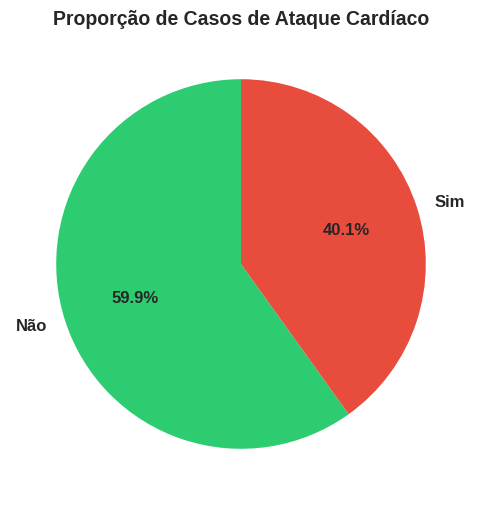

In [10]:
#entender a distribuição da variável alvo 'heart_attack'

target_counts = df['heart_attack'].value_counts()
colors = ['#2ecc71', '#e74c3c']

plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=['Não', 'Sim'], autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Proporção de Casos de Ataque Cardíaco', fontsize=14, fontweight='bold')
plt.show()


### 3.4 Distribuição da Variável Alvo

**Importância da Análise de Balanceamento:**

A variável alvo `heart_attack` indica se o paciente sofreu um ataque cardíaco (1) ou não (0). É crucial verificar se as classes estão balanceadas, pois:

- **Dataset desbalanceado** pode fazer o modelo tender a prever sempre a classe majoritária
- **Acurácia pode ser enganosa** em casos de desbalanceamento severo
- **Técnicas especiais** (SMOTE, class weights, etc.) podem ser necessárias se o desbalanceamento for significativo

**Interpretação:**
- Balanceamento ideal: próximo de 50%-50%
- Desbalanceamento leve: 60%-40%
- Desbalanceamento moderado: 70%-30%
- Desbalanceamento severo: acima de 80%-20%

## 4. Análise Exploratória de Dados (EDA)

A Análise Exploratória de Dados é uma etapa crucial para entender os padrões, relações e características do dataset antes de aplicar modelos de Machine Learning.

**Objetivos da EDA:**

1. **Identificar relações entre variáveis e o target**: Quais fatores mais influenciam o risco de ataque cardíaco?
2. **Detectar padrões e tendências**: Existem grupos de risco específicos?
3. **Validar hipóteses clínicas**: Os dados confirmam conhecimentos médicos estabelecidos?
4. **Preparar para feature engineering**: Identificar oportunidades de criar novas variáveis

### 4.1 Análise de Variáveis Categóricas

**Por que analisar variáveis categóricas?**

Variáveis categóricas como `gender`, `smoking_status`, `dietary_habits` etc. frequentemente apresentam forte associação com desfechos clínicos. A análise cruzada dessas variáveis com o target nos permite:

- Identificar **grupos de alto risco** (ex: fumantes, sedentários)
- Entender **fatores modificáveis** que podem ser alvo de intervenções
- Visualizar **proporções de casos positivos** em cada categoria

**Interpretação dos gráficos:**
- Barras vermelhas: percentual de pacientes COM ataque cardíaco
- Barras verdes: percentual de pacientes SEM ataque cardíaco
- Quanto maior a barra vermelha, maior o risco associado àquela categoria

In [43]:
#Identificar variáveis categóricas ou de agrupamento 
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Variáveis Categóricas:")
print(categorical_cols)
print(f"\nTotal: {len(categorical_cols)} variáveis categorizadoras")

Variáveis Categóricas:
['gender', 'region', 'income_level', 'smoking_status', 'alcohol_consumption', 'physical_activity', 'dietary_habits', 'air_pollution_exposure', 'stress_level', 'EKG_results']

Total: 10 variáveis categorizadoras


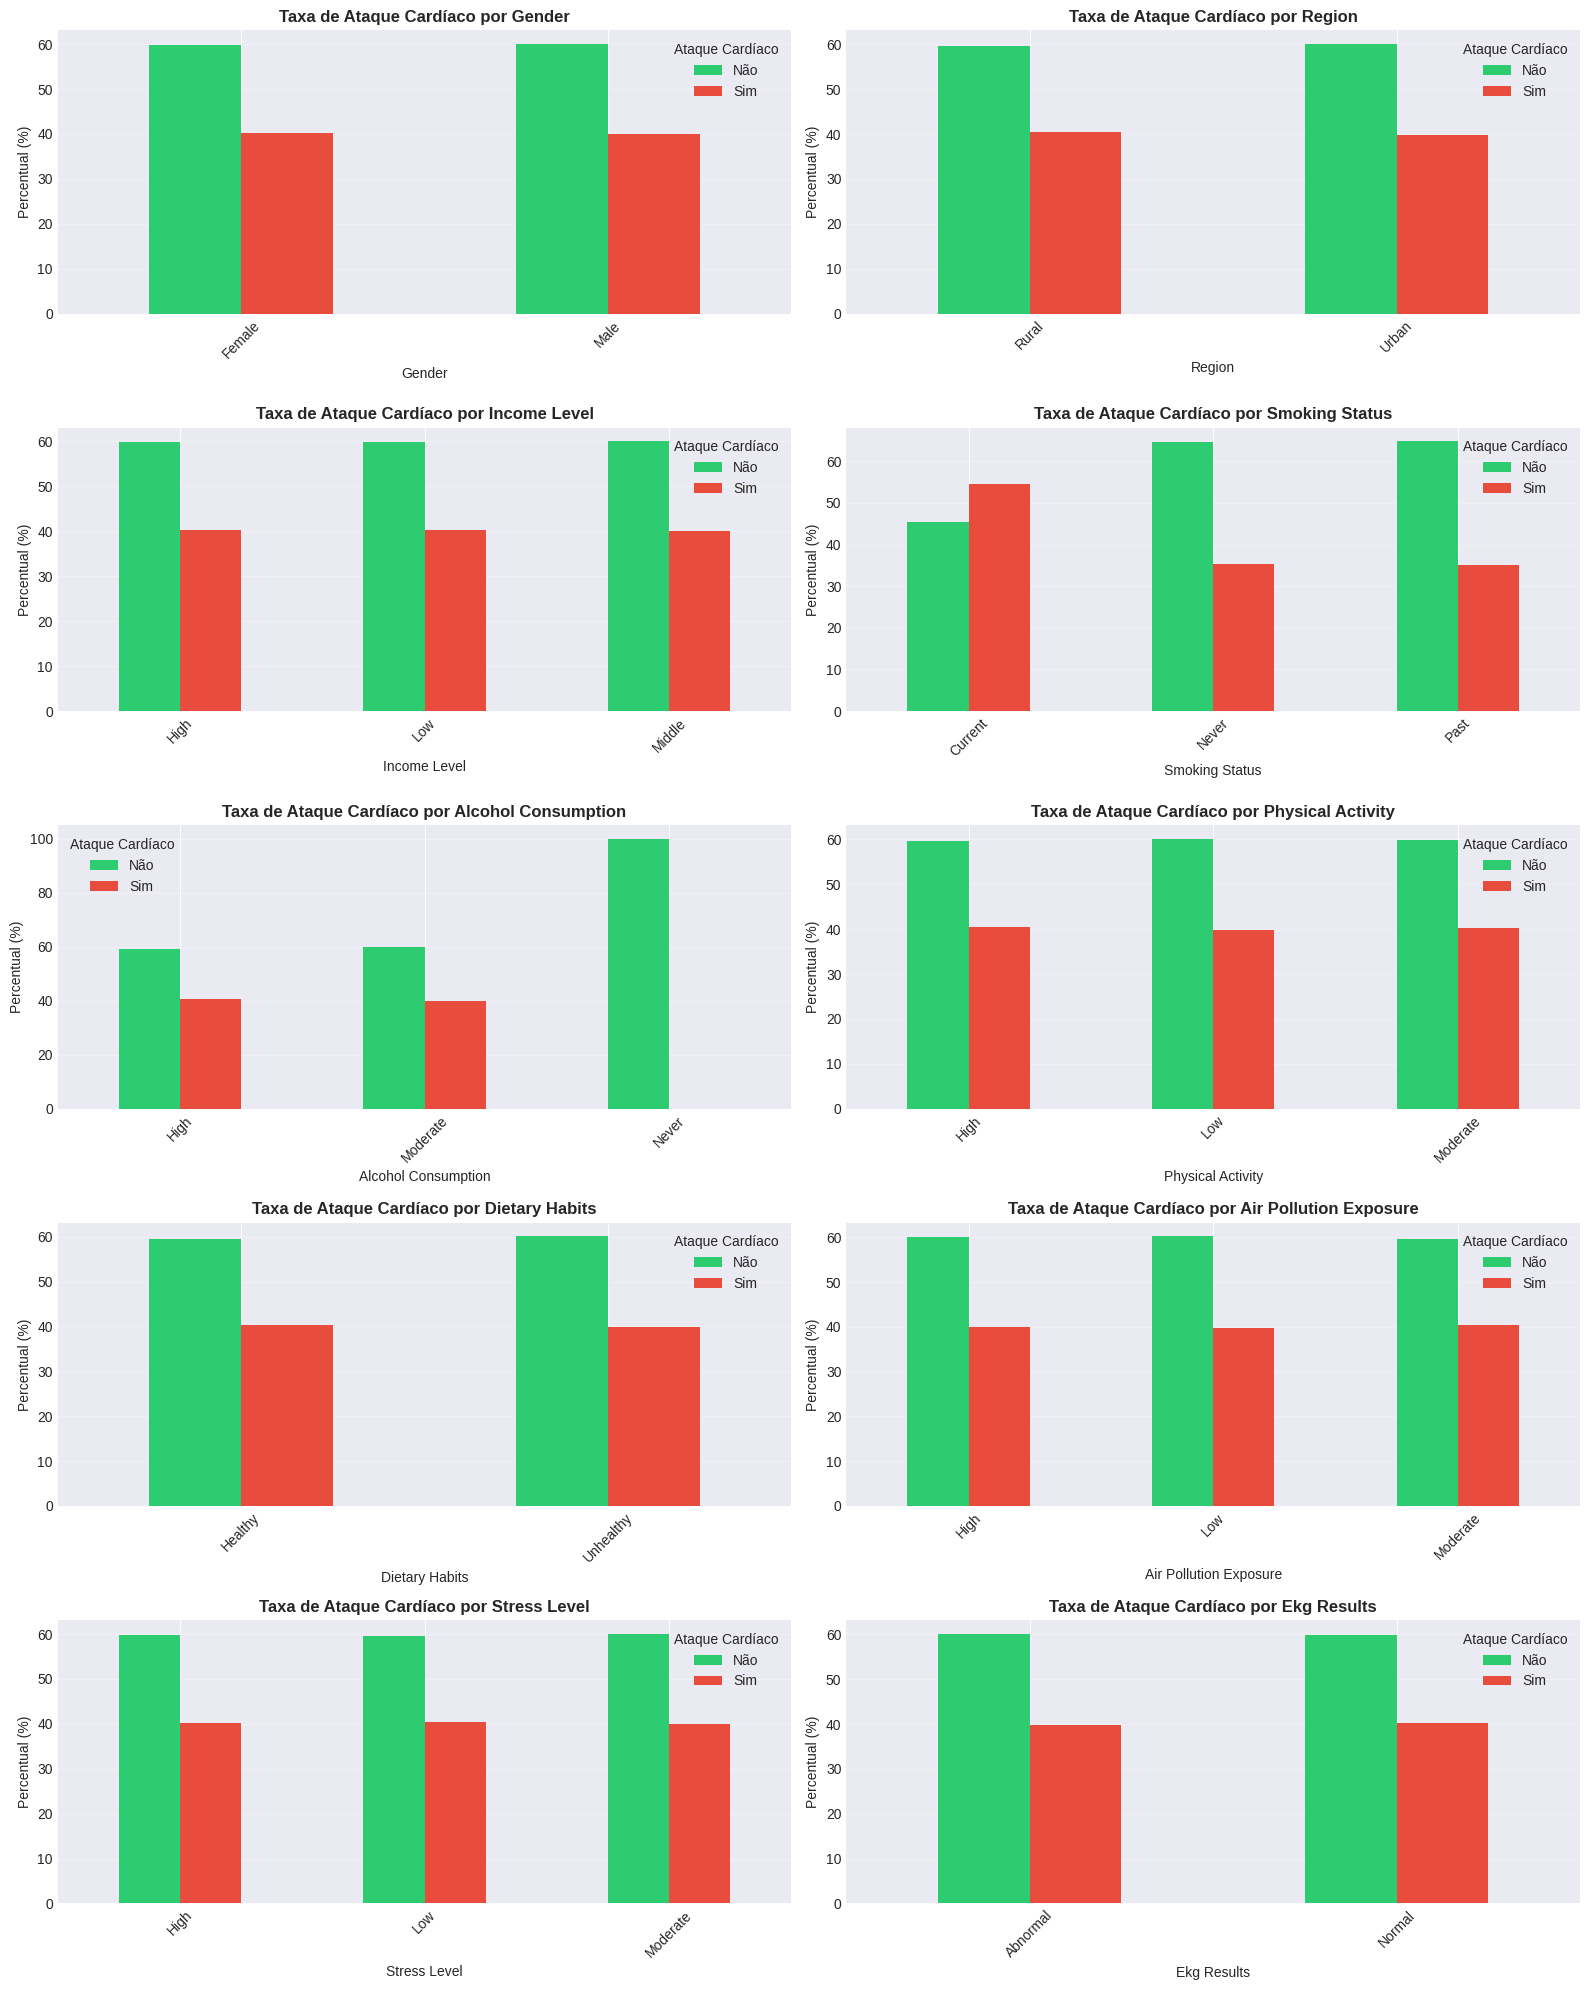

In [44]:
# Análise de variáveis categóricas vs target


fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols):
    if col in df.columns:
        cross_tab = pd.crosstab(df[col], df['heart_attack'], normalize='index') * 100
        cross_tab.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'])
        axes[idx].set_title(f'Taxa de Ataque Cardíaco por {col.replace("_", " ").title()}', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col.replace('_', ' ').title(), fontsize=10)
        axes[idx].set_ylabel('Percentual (%)', fontsize=10)
        axes[idx].legend(['Não', 'Sim'], title='Ataque Cardíaco')
        axes[idx].grid(axis='y', alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 4.2 Análise de Variáveis Numéricas

**Importância das Variáveis Numéricas:**

Variáveis numéricas como idade, níveis de colesterol, pressão arterial e glicemia fornecem medidas quantitativas importantes para predição de risco cardiovascular.

**Análises Realizadas:**

1. **Histogramas com separação por target:**
   - Distribuição Verde: pacientes SEM ataque cardíaco
   - Distribuição Vermelha: pacientes COM ataque cardíaco
   - **Objetivo**: Identificar se há diferença nas distribuições entre os grupos

2. **Boxplots por target:**
   - Detectam outliers (pontos fora das caixas)
   - Mostram medianas (linha vermelha) e quartis (caixas)
   - **Objetivo**: Comparar valores típicos entre pacientes com e sem ataque cardíaco

**O que procurar:**
- **Separação clara** entre distribuições → variável potencialmente preditiva
- **Sobreposição total** → variável menos útil para predição
- **Outliers** → casos extremos que podem ser clinicamente relevantes

In [45]:
    # Identificar variáveis numéricas 
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('heart_attack')  # Remover a variável comparativa 

print("Variáveis Numéricas:")
print(numerical_cols)
print(f"\nTotal: {len(numerical_cols)} variáveis numéricas")

Variáveis Numéricas:
['age', 'hypertension', 'diabetes', 'cholesterol_level', 'obesity', 'waist_circumference', 'family_history', 'sleep_hours', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'fasting_blood_sugar', 'cholesterol_hdl', 'cholesterol_ldl', 'triglycerides', 'previous_heart_disease', 'medication_usage', 'participated_in_free_screening', 'alcohol_missing']

Total: 18 variáveis numéricas


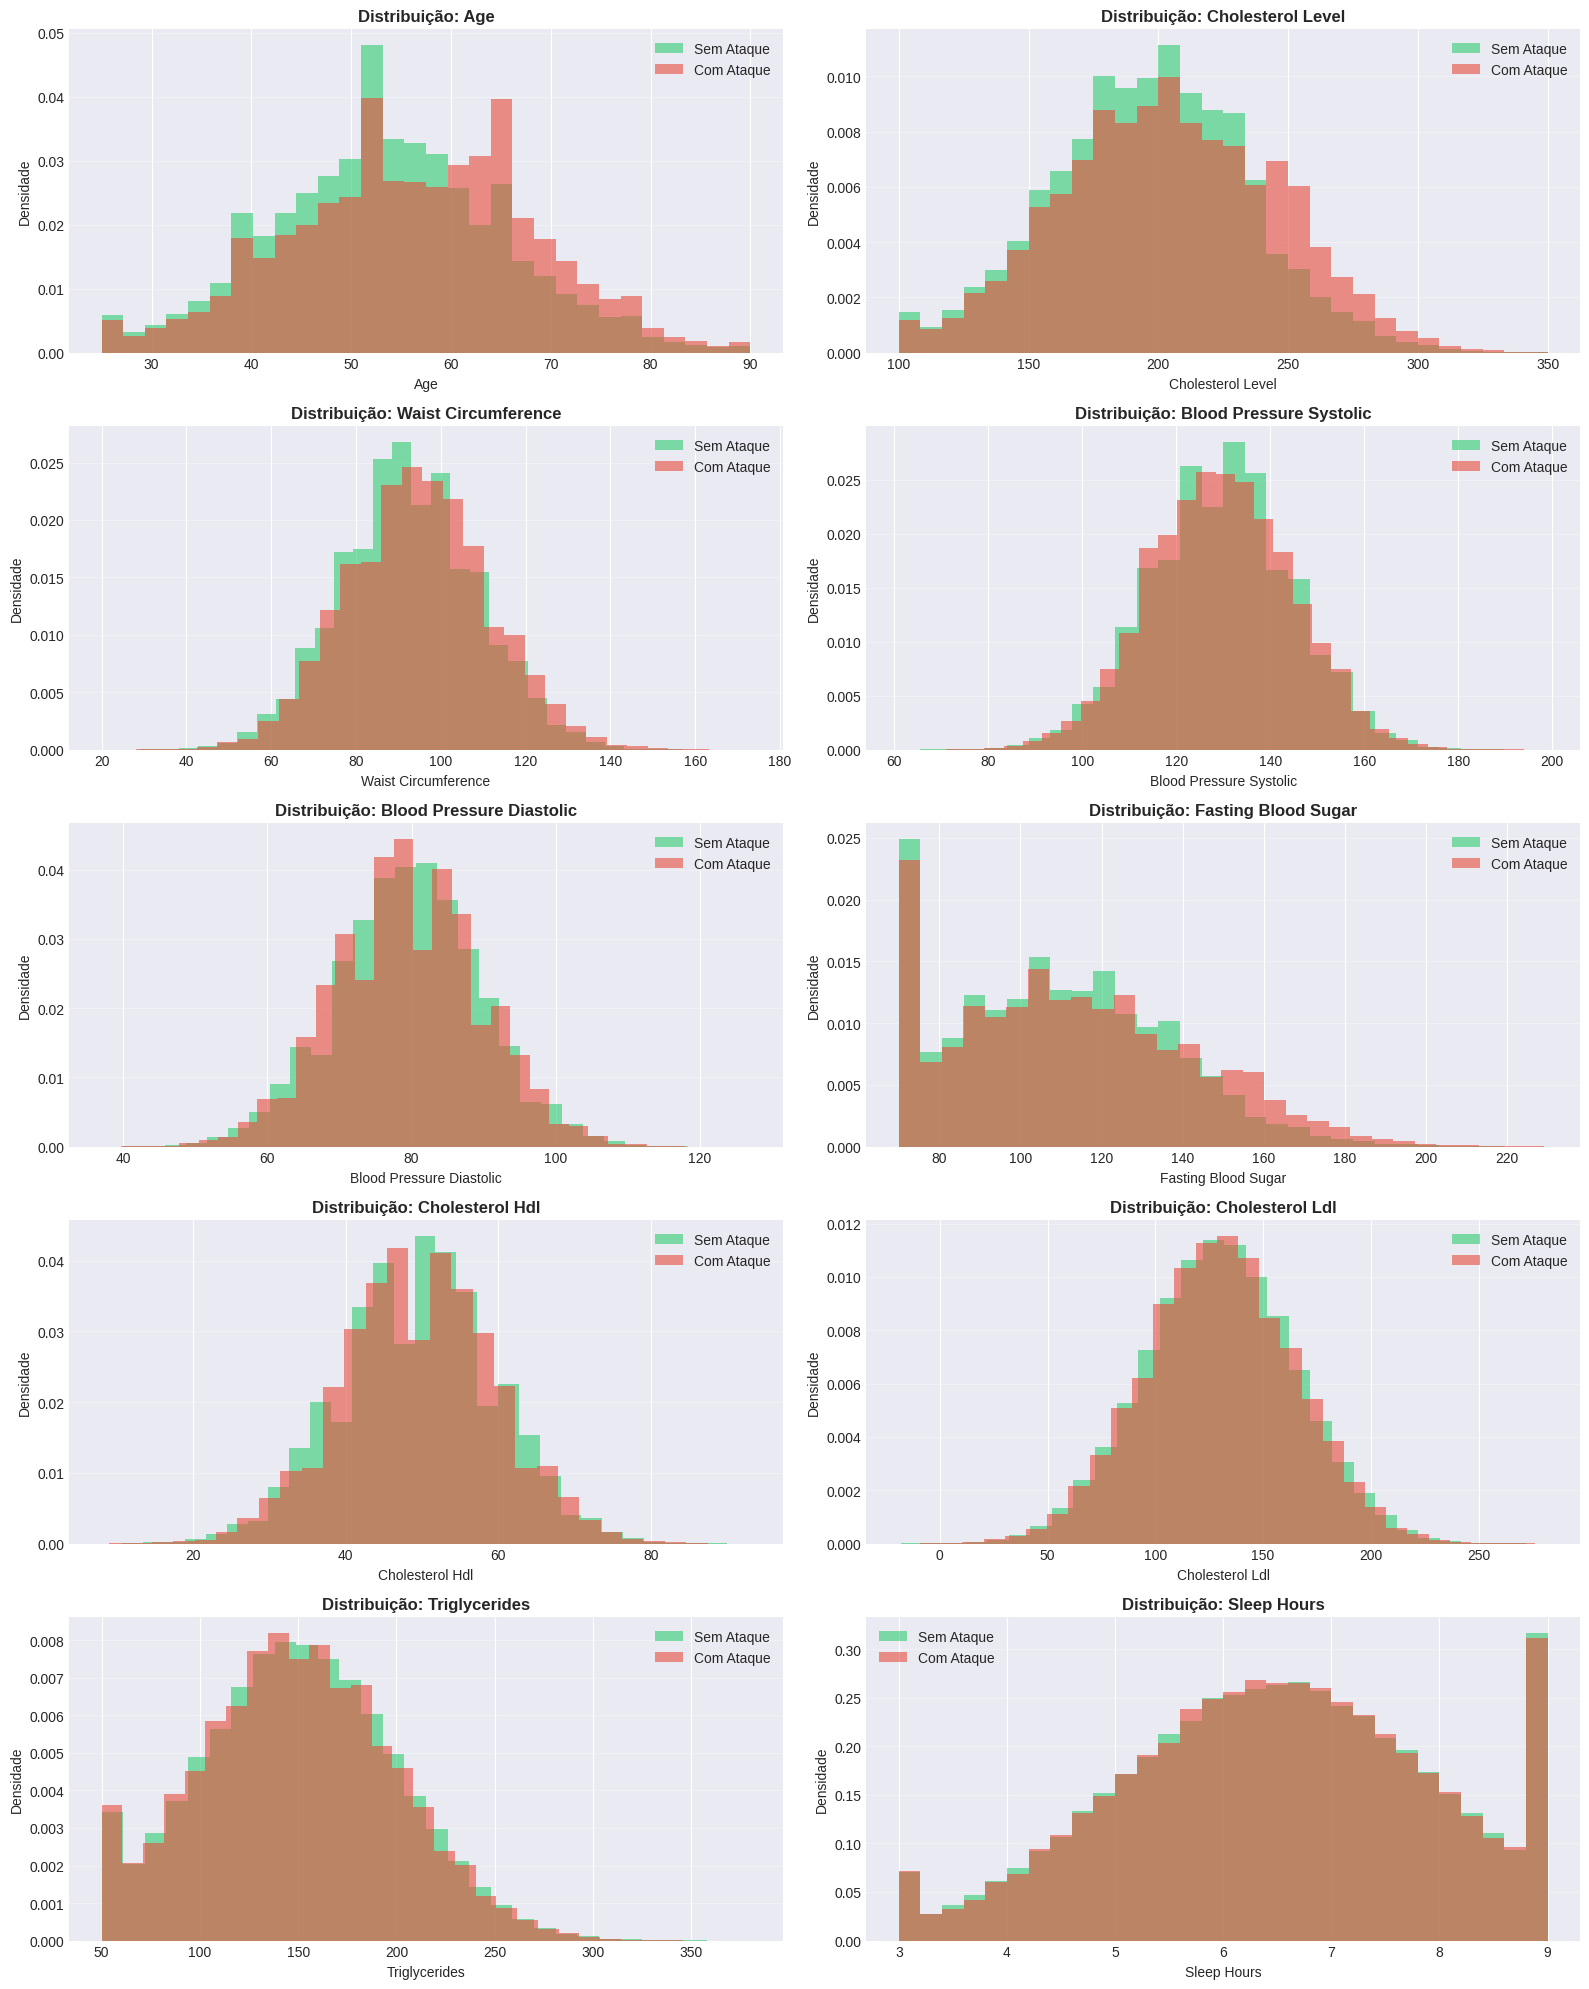

In [14]:
# Distribuição das principais variáveis numéricas
key_numerical = ['age', 'cholesterol_level', 'waist_circumference', 'blood_pressure_systolic',
                'blood_pressure_diastolic', 'fasting_blood_sugar', 'cholesterol_hdl',
                'cholesterol_ldl', 'triglycerides', 'sleep_hours']

fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.ravel()

for idx, col in enumerate(key_numerical):
    if col in df.columns:
        # Histograma com KDE
        df[df['heart_attack'] == 0][col].hist(ax=axes[idx], bins=30, alpha=0.6, 
                                               label='Sem Ataque', color='#2ecc71', density=True)
        df[df['heart_attack'] == 1][col].hist(ax=axes[idx], bins=30, alpha=0.6, 
                                               label='Com Ataque', color='#e74c3c', density=True)
        
        axes[idx].set_title(f'Distribuição: {col.replace("_", " ").title()}', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col.replace('_', ' ').title(), fontsize=10)
        axes[idx].set_ylabel('Densidade', fontsize=10)
        axes[idx].legend()
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
#plt.savefig('numerical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

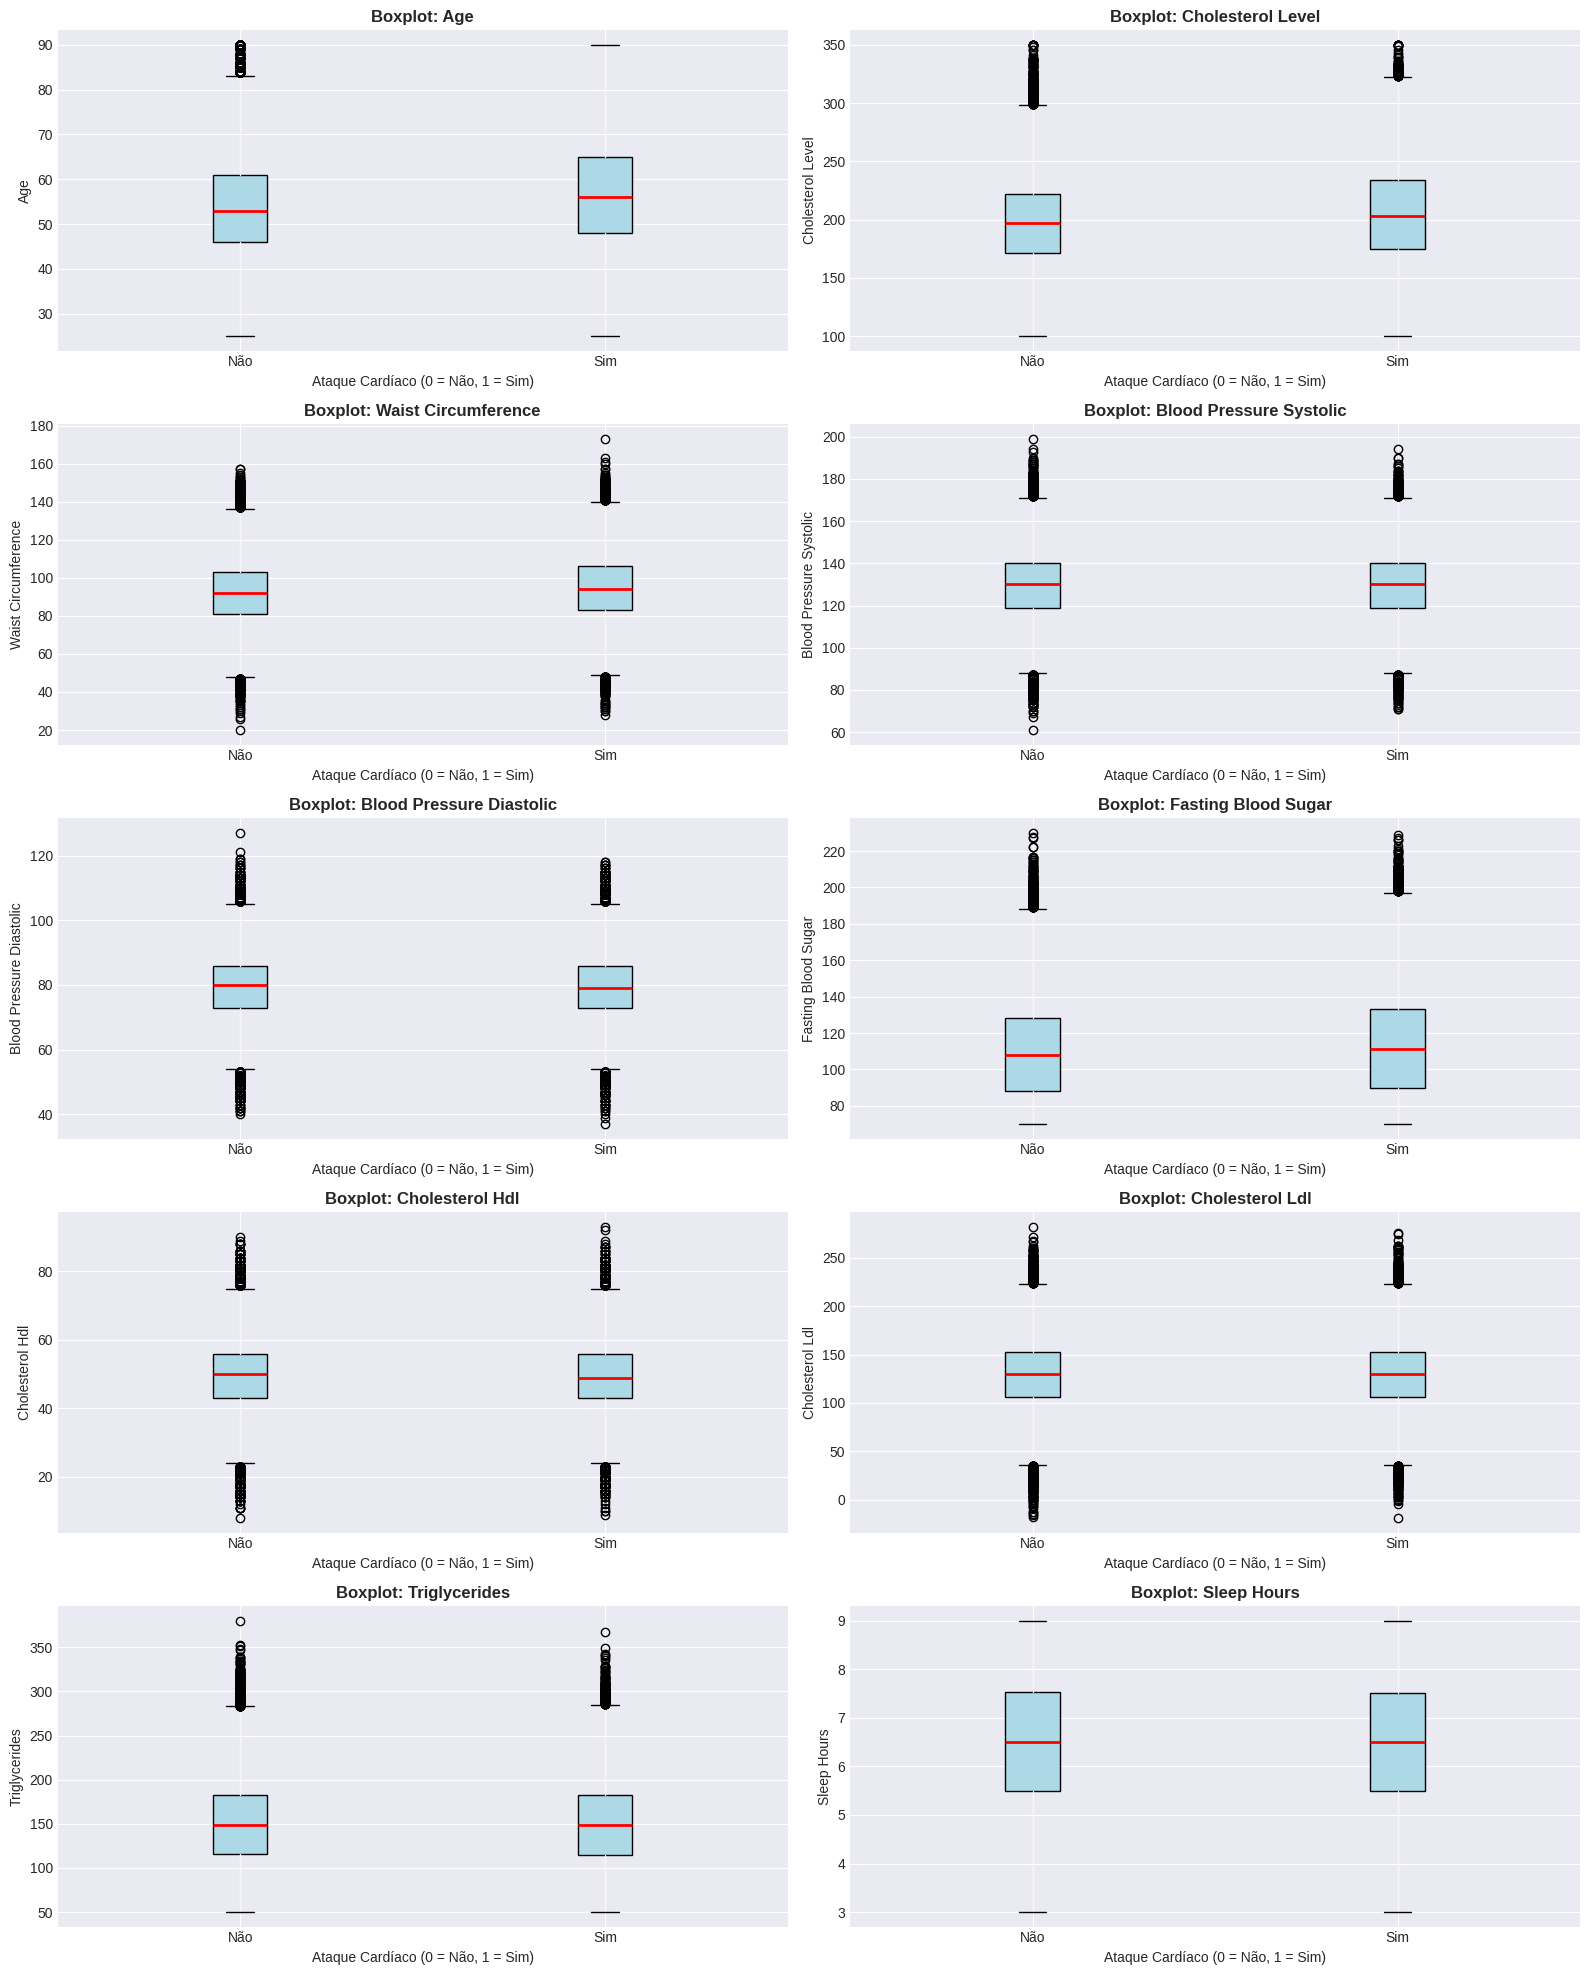

In [15]:
# Boxplots para detectar outliers
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.ravel()

for idx, col in enumerate(key_numerical):
    if col in df.columns:
        df.boxplot(column=col, by='heart_attack', ax=axes[idx], 
                  patch_artist=True, 
                  boxprops=dict(facecolor='lightblue'),
                  medianprops=dict(color='red', linewidth=2))
        axes[idx].set_title(f'Boxplot: {col.replace("_", " ").title()}', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Ataque Cardíaco (0 = Não, 1 = Sim)', fontsize=10)
        axes[idx].set_ylabel(col.replace('_', ' ').title(), fontsize=10)
        plt.sca(axes[idx])
        plt.xticks([1, 2], ['Não', 'Sim'])

plt.suptitle('')  # Remove o título automático do pandas
plt.tight_layout()
#plt.savefig('numerical_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.3 Análise de Correlação

**O que é Correlação?**

A correlação mede a força e direção da relação linear entre duas variáveis, variando de -1 a +1:

- **+1**: correlação positiva perfeita (quando uma aumenta, a outra também aumenta)
- **0**: sem correlação linear
- **-1**: correlação negativa perfeita (quando uma aumenta, a outra diminui)

**Interpretação dos Valores:**
- 0.0 - 0.2: correlação muito fraca
- 0.2 - 0.4: correlação fraca
- 0.4 - 0.6: correlação moderada
- 0.6 - 0.8: correlação forte
- 0.8 - 1.0: correlação muito forte

**Por que isso importa?**

1. **Seleção de features**: Variáveis altamente correlacionadas com o target são bons preditores
2. **Multicolinearidade**: Variáveis muito correlacionadas entre si podem causar problemas em alguns modelos
3. **Insights clínicos**: Confirmar ou descobrir relações entre fatores de risco

**Nota Importante**: Correlação não implica causalidade! Uma correlação forte não significa que uma variável causa a outra.

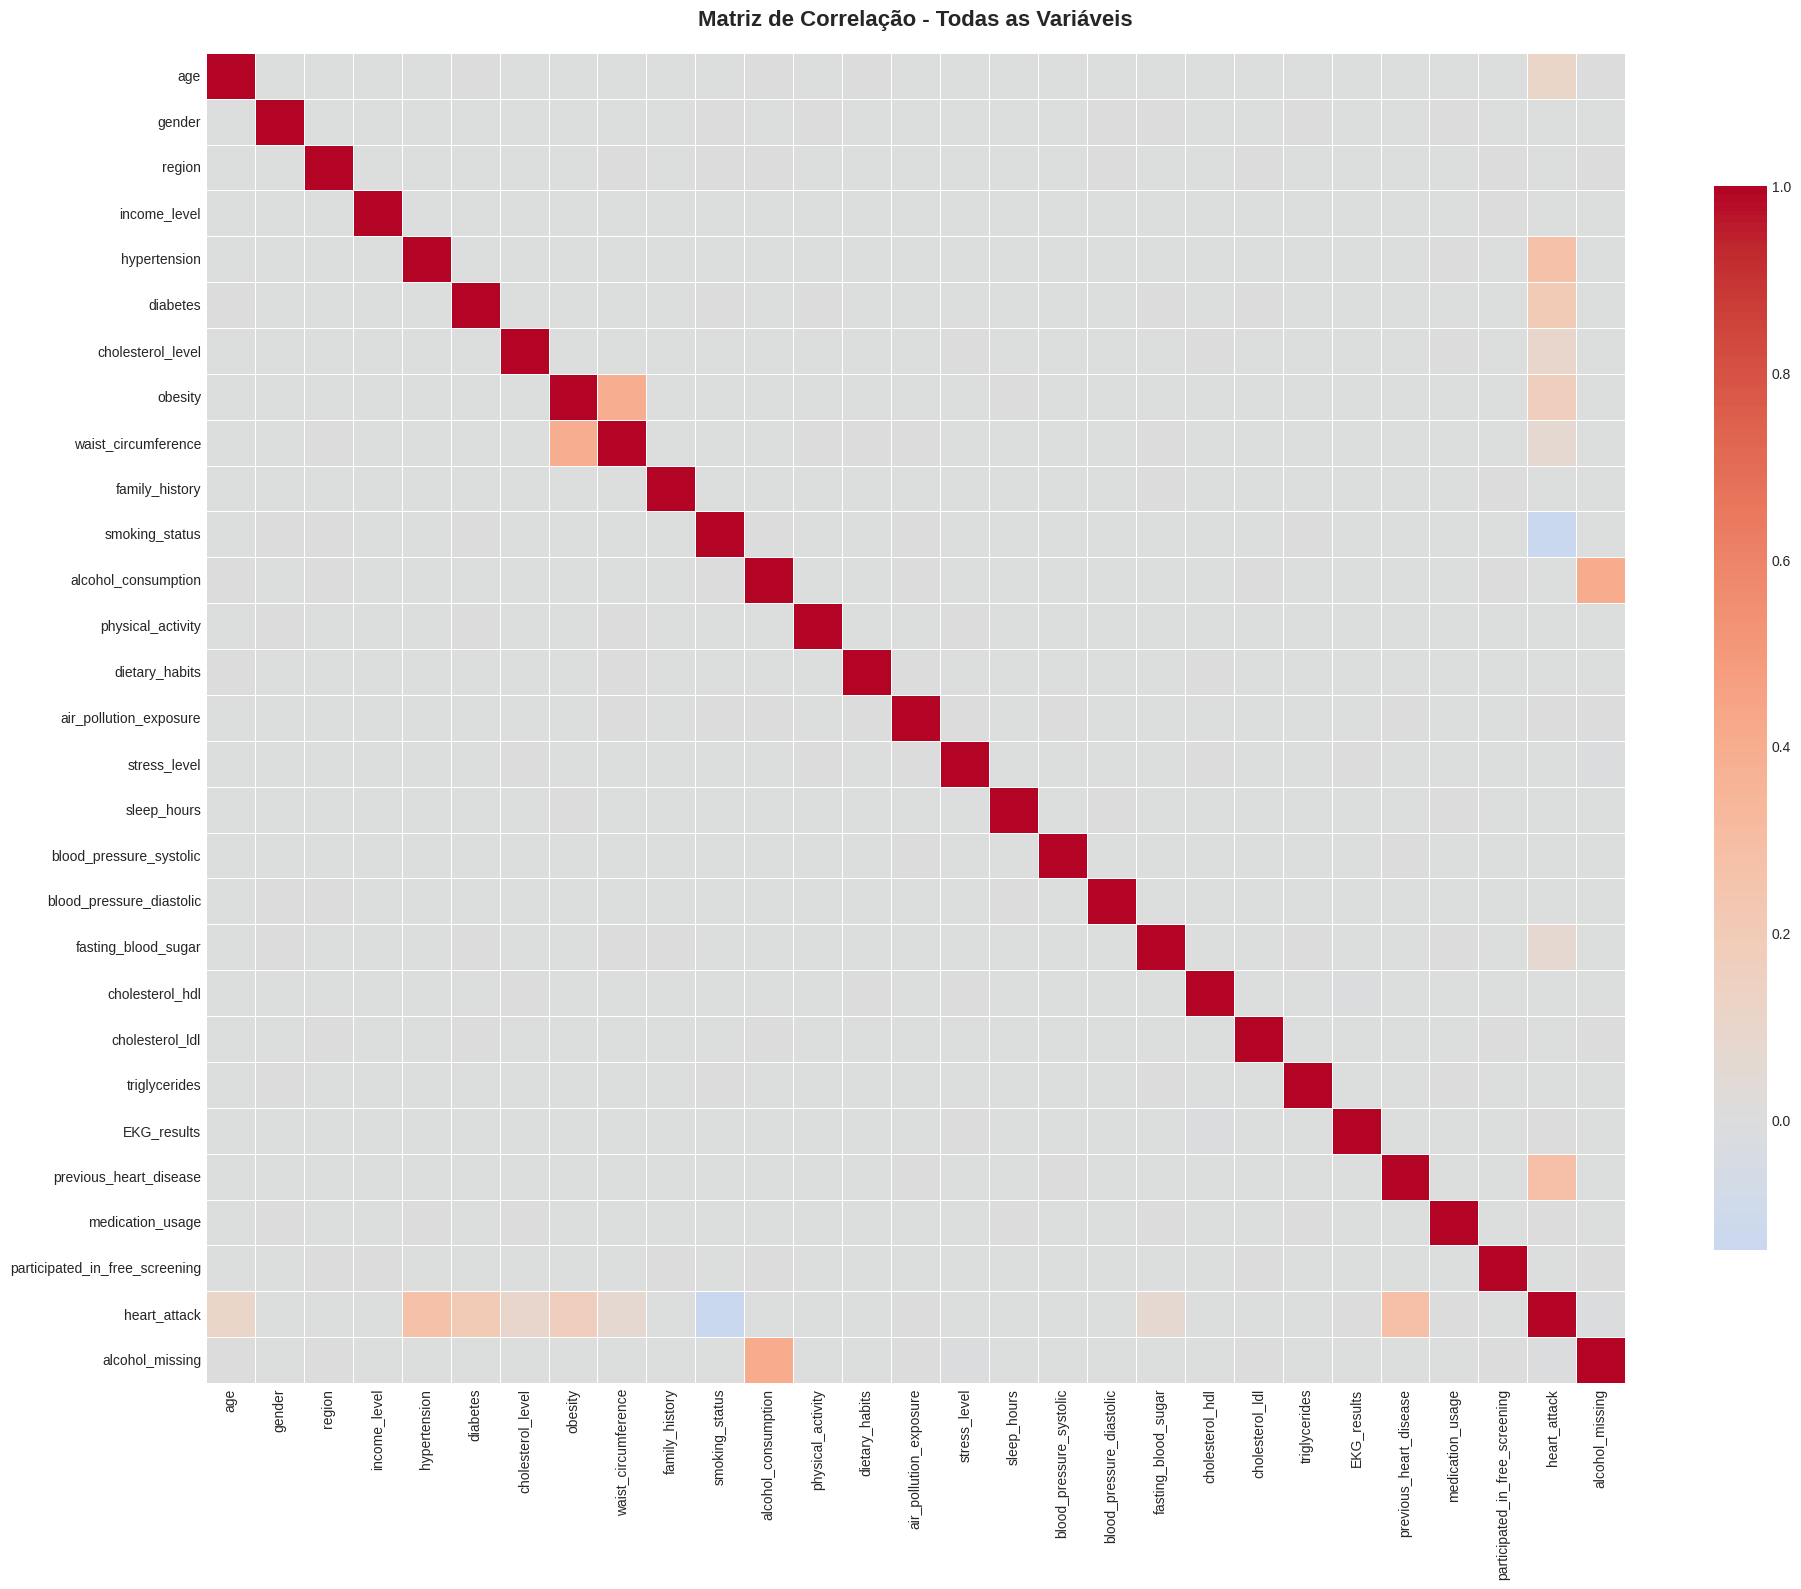

In [16]:
# Criar uma cópia do dataframe para análise de correlação
df_corr = df.copy()

# Codificar variáveis categóricas para análise de correlação
le = LabelEncoder()
for col in categorical_cols:
    if col in df_corr.columns:
        df_corr[col] = le.fit_transform(df_corr[col].astype(str))

# Calcular matriz de correlação
correlation_matrix = df_corr.corr()

# Visualizar matriz de correlação completa
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação - Todas as Variáveis', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
#plt.savefig('correlation_matrix_full.png', dpi=300, bbox_inches='tight')
plt.show()

CORRELAÇÃO DAS VARIÁVEIS COM HEART_ATTACK (em %)
heart_attack                      100.00
previous_heart_disease             27.48
hypertension                       26.93
diabetes                           19.45
obesity                            17.17
age                                10.58
cholesterol_level                   9.26
fasting_blood_sugar                 6.98
waist_circumference                 6.79
medication_usage                    0.47
air_pollution_exposure              0.39
EKG_results                         0.26
family_history                      0.14
sleep_hours                         0.07
cholesterol_hdl                     0.06
cholesterol_ldl                     0.06
blood_pressure_diastolic           -0.03
triglycerides                      -0.07
physical_activity                  -0.07
blood_pressure_systolic            -0.16
income_level                       -0.19
stress_level                       -0.34
gender                             -0.35
particip

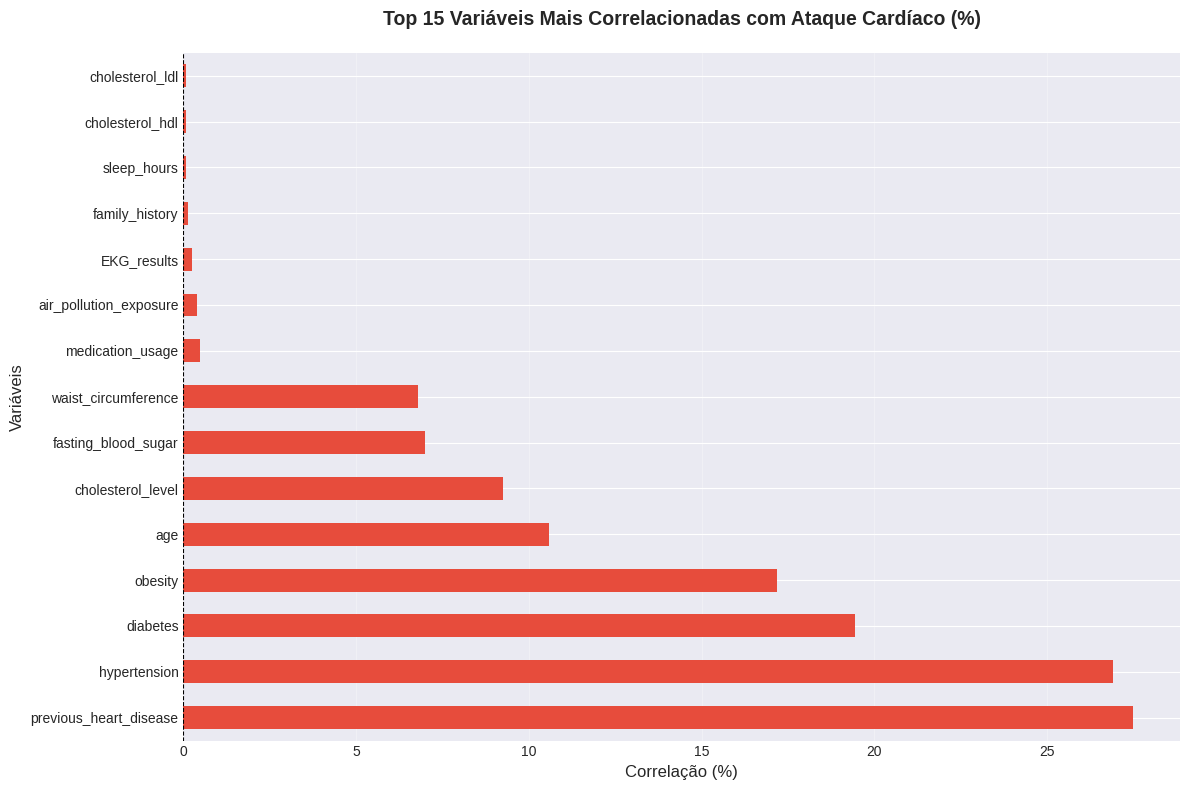

In [46]:
# Correlação com a variável target
target_correlation = correlation_matrix['heart_attack'].sort_values(ascending=False)

# Converter correlação em porcentagem
target_correlation_percent = target_correlation * 100

print("CORRELAÇÃO DAS VARIÁVEIS COM HEART_ATTACK (em %)")
print(target_correlation_percent.round(2))  # Arredondar para 2 casas decimais

# Visualizar top 15 correlações com o target
plt.figure(figsize=(12, 8))
top_corr = target_correlation_percent[1:16]  # Excluir a própria variável target

# Cores para correlações positivas e negativas
colors = ['#e74c3c' if x > 0 else '#3498db' for x in top_corr]

# Gráfico
top_corr.plot(kind='barh', color=colors)
plt.title('Top 15 Variáveis Mais Correlacionadas com Ataque Cardíaco (%)', 
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Correlação (%)', fontsize=12)
plt.ylabel('Variáveis', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Pré-processamento de Dados

O pré-processamento é uma etapa fundamental que transforma os dados brutos em um formato adequado para os algoritmos de Machine Learning.

**Por que pré-processar?**

1. **Modelos de ML não entendem texto**: Variáveis categóricas precisam ser convertidas em números
2. **Escalas diferentes prejudicam o aprendizado**: Variáveis com escalas muito diferentes (ex: idade 0-100 vs triglicerídeos 0-500) precisam ser normalizadas
3. **Divisão treino/teste previne vazamento de dados**: Garante que o modelo seja avaliado em dados "novos"

### 5.1 Tratamento de Valores Ausentes e Inconsistências

**Estratégia de Tratamento:**

Nesta seção, verificamos a existência de valores inconsistentes que possam ter passado pela limpeza inicial, como:
- Valores negativos em variáveis que não deveriam tê-los
- Valores fora de faixas biologicamente plausíveis
- Padrões inesperados que possam indicar erros de coleta

**Princípio**: Sempre validar os dados antes de alimentar o modelo!

In [47]:
# Verificar valores inconsistentes em variáveis numéricas

print("VERIFICAÇÃO DE VALORES INCONSISTENTES")
# Verificar valores negativos onde não deveriam existir
numerical_positive = ['age', 'cholesterol_level', 'waist_circumference', 'blood_pressure_systolic',
                     'blood_pressure_diastolic', 'fasting_blood_sugar', 'cholesterol_hdl',
                     'cholesterol_ldl', 'triglycerides', 'sleep_hours']

for col in numerical_positive:
    if col in df.columns:
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            print(f"⚠️ {col}: {negative_count} valores negativos encontrados")
        else:
            print(f"✓ {col}: Sem valores negativos")

print("\n✓ Verificação de inconsistências concluída.")

VERIFICAÇÃO DE VALORES INCONSISTENTES
✓ age: Sem valores negativos
✓ cholesterol_level: Sem valores negativos
✓ waist_circumference: Sem valores negativos
✓ blood_pressure_systolic: Sem valores negativos
✓ blood_pressure_diastolic: Sem valores negativos
✓ fasting_blood_sugar: Sem valores negativos
✓ cholesterol_hdl: Sem valores negativos
⚠️ cholesterol_ldl: 14 valores negativos encontrados
✓ triglycerides: Sem valores negativos
✓ sleep_hours: Sem valores negativos

✓ Verificação de inconsistências concluída.


### 5.2 Pipeline de Pré-processamento

O pipeline de pré-processamento organiza de forma sequencial todas as transformações necessárias nos dados.

**Etapas do Pipeline:**

1. **Separação X (features) e y (target)**: Isolar a variável que queremos prever
2. **Codificação de variáveis categóricas**: Converter texto em números (Label Encoding)
3. **Divisão treino/validação/teste**: Criar conjuntos independentes para treinamento e avaliação
4. **Normalização**: Padronizar as escalas das variáveis numéricas

**Por que dividir em 3 conjuntos?**

- **Treino (70%)**: Usado para treinar o modelo
- **Validação (15%)**: Usado para ajustar hiperparâmetros e comparar modelos
- **Teste (15%)**: Usado APENAS no final para avaliação imparcial do melhor modelo

Isso previne overfitting e fornece uma estimativa realista do desempenho em produção.

In [19]:
# Separar features e target
X = df.drop('heart_attack', axis=1)
y = df['heart_attack']


print("SEPARAÇÃO DE FEATURES E TARGET")

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")
print(f"\nDistribuição do target:")
print(y.value_counts())

print("\nDistribuição do target (em %):")
print((y.value_counts(normalize=True) * 100).round(2))

SEPARAÇÃO DE FEATURES E TARGET
Shape de X (features): (158356, 28)
Shape de y (target): (158356,)

Distribuição do target:
heart_attack
0    94855
1    63501
Name: count, dtype: int64

Distribuição do target (em %):
heart_attack
0    59.9
1    40.1
Name: proportion, dtype: float64


In [20]:
# Codificar variáveis categóricas

print("CODIFICAÇÃO DE VARIÁVEIS CATEGÓRICAS")


X_encoded = X.copy()
label_encoders = {}

for col in categorical_cols:
    if col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le
        print(f"✓ {col}: {len(le.classes_)} categorias codificadas")

print(f"\n✓ Total de {len(label_encoders)} variáveis categóricas codificadas.")

CODIFICAÇÃO DE VARIÁVEIS CATEGÓRICAS
✓ gender: 2 categorias codificadas
✓ region: 2 categorias codificadas
✓ income_level: 3 categorias codificadas
✓ smoking_status: 3 categorias codificadas
✓ alcohol_consumption: 3 categorias codificadas
✓ physical_activity: 3 categorias codificadas
✓ dietary_habits: 2 categorias codificadas
✓ air_pollution_exposure: 3 categorias codificadas
✓ stress_level: 3 categorias codificadas
✓ EKG_results: 2 categorias codificadas

✓ Total de 10 variáveis categóricas codificadas.


In [21]:
# Divisão em conjuntos de treino, validação e teste

print("DIVISÃO DOS DADOS: TREINO, VALIDAÇÃO E TESTE")
print("="*80)

# Primeiro split: 70% treino, 30% temporário (validação + teste)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

# Segundo split: dividir os 30% em 15% validação e 15% teste
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Conjunto de Treino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Conjunto de Validação: {X_val.shape[0]} amostras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Conjunto de Teste: {X_test.shape[0]} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nDistribuição do target em cada conjunto:")
print(f"Treino: {y_train.value_counts().to_dict()}")
print(f"Validação: {y_val.value_counts().to_dict()}")
print(f"Teste: {y_test.value_counts().to_dict()}")

DIVISÃO DOS DADOS: TREINO, VALIDAÇÃO E TESTE
Conjunto de Treino: 110849 amostras (70.0%)
Conjunto de Validação: 23753 amostras (15.0%)
Conjunto de Teste: 23754 amostras (15.0%)

Distribuição do target em cada conjunto:
Treino: {0: 66398, 1: 44451}
Validação: {0: 14228, 1: 9525}
Teste: {0: 14229, 1: 9525}


In [22]:
# Normalização das features

print("NORMALIZAÇÃO DAS FEATURES")
print("="*80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Features normalizadas usando StandardScaler")
print(f"\nMédia das features após normalização (treino): {X_train_scaled.mean():.6f}")
print(f"Desvio padrão das features após normalização (treino): {X_train_scaled.std():.6f}")

NORMALIZAÇÃO DAS FEATURES
✓ Features normalizadas usando StandardScaler

Média das features após normalização (treino): -0.000000
Desvio padrão das features após normalização (treino): 1.000000


## 6. Modelagem de Machine Learning

A modelagem é o coração do projeto, onde aplicamos algoritmos que aprendem padrões dos dados para fazer predições.

**Estratégia de Modelagem:**

Testaremos múltiplos algoritmos para identificar qual tem melhor desempenho neste problema específico. Cada algoritmo tem características diferentes:

### 6.1 Seleção e Treinamento de Modelos

**Modelos Selecionados:**

1. **Regressão Logística**
   - **Tipo**: Linear
   - **Vantagens**: Simples, rápido, muito interpretável
   - **Quando usar**: Baseline, relações lineares
   - **Interpretação**: Coeficientes mostram impacto de cada variável

2. **Árvore de Decisão**
   - **Tipo**: Não-linear, baseado em regras
   - **Vantagens**: Fácil interpretação, captura interações
   - **Desvantagens**: Tende a overfitting
   - **Interpretação**: Sequência de decisões em forma de árvore

3. **Random Forest**
   - **Tipo**: Ensemble de árvores
   - **Vantagens**: Robusto, lida bem com não-linearidades, reduz overfitting
   - **Como funciona**: Combina múltiplas árvores de decisão
   - **Interpretação**: Feature importance mostra variáveis mais relevantes

4. **K-Nearest Neighbors (KNN)**
   - **Tipo**: Baseado em instâncias
   - **Vantagens**: Simples, não paramétrico
   - **Como funciona**: Classifica baseado nos K vizinhos mais próximos
   - **Desvantagens**: Sensível à escala e ao valor de K

**Métricas de Avaliação:**

- **Accuracy**: % de predições corretas (cuidado com desbalanceamento!)
- **Precision**: Dos que o modelo disse "sim", quantos estavam certos?
- **Recall**: Dos que eram "sim", quantos o modelo acertou?
- **F1-Score**: Média harmônica entre Precision e Recall (MÉTRICA PRINCIPAL)
- **ROC-AUC**: Capacidade de separar as classes em diferentes thresholds

In [23]:
# Definir modelos a serem testados
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    #'SVM': SVC(random_state=42, probability=True)
}


print("MODELOS SELECIONADOS PARA TREINAMENTO")

for i, (name, model) in enumerate(models.items(), 1):
    print(f"{i}. {name}")

MODELOS SELECIONADOS PARA TREINAMENTO
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. KNN


In [24]:
# Treinar e avaliar modelos
print("\n" + "="*80)
print("TREINAMENTO E AVALIAÇÃO DOS MODELOS")


results = []
trained_models = {}

for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Treinando: {name}")
    print(f"{'='*80}")
    
    # Treinar o modelo
    model.fit(X_train_scaled, y_train)
    
    # Predições no conjunto de validação
    y_val_pred = model.predict(X_val_scaled)
    y_val_pred_proba = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calcular métricas
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_pred_proba) if y_val_pred_proba is not None else None
    
    # Armazenar resultados
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    trained_models[name] = model
    
    print(f"✓ Accuracy: {accuracy:.4f}")
    print(f"✓ Precision: {precision:.4f}")
    print(f"✓ Recall: {recall:.4f}")
    print(f"✓ F1-Score: {f1:.4f}")
    if roc_auc:
        print(f"✓ ROC-AUC: {roc_auc:.4f}")

# Criar DataFrame com resultados
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)


print("RESUMO COMPARATIVO DOS MODELOS (CONJUNTO DE VALIDAÇÃO)")

print(results_df.to_string(index=False))


TREINAMENTO E AVALIAÇÃO DOS MODELOS

Treinando: Logistic Regression
✓ Accuracy: 0.7282
✓ Precision: 0.6893
✓ Recall: 0.5865
✓ F1-Score: 0.6337
✓ ROC-AUC: 0.7996

Treinando: Decision Tree
✓ Accuracy: 0.6580
✓ Precision: 0.5731
✓ Recall: 0.5770
✓ F1-Score: 0.5750
✓ ROC-AUC: 0.6446

Treinando: Random Forest
✓ Accuracy: 0.7311
✓ Precision: 0.6879
✓ Recall: 0.6029
✓ F1-Score: 0.6426
✓ ROC-AUC: 0.8084

Treinando: KNN
✓ Accuracy: 0.6801
✓ Precision: 0.6334
✓ Recall: 0.4800
✓ F1-Score: 0.5461
✓ ROC-AUC: 0.7182
RESUMO COMPARATIVO DOS MODELOS (CONJUNTO DE VALIDAÇÃO)
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.731066   0.687867 0.602940  0.642609 0.808388
Logistic Regression  0.728161   0.689289 0.586457  0.633729 0.799550
      Decision Tree  0.658022   0.573097 0.577008  0.575046 0.644633
                KNN  0.680083   0.633416 0.480000  0.546139 0.718189


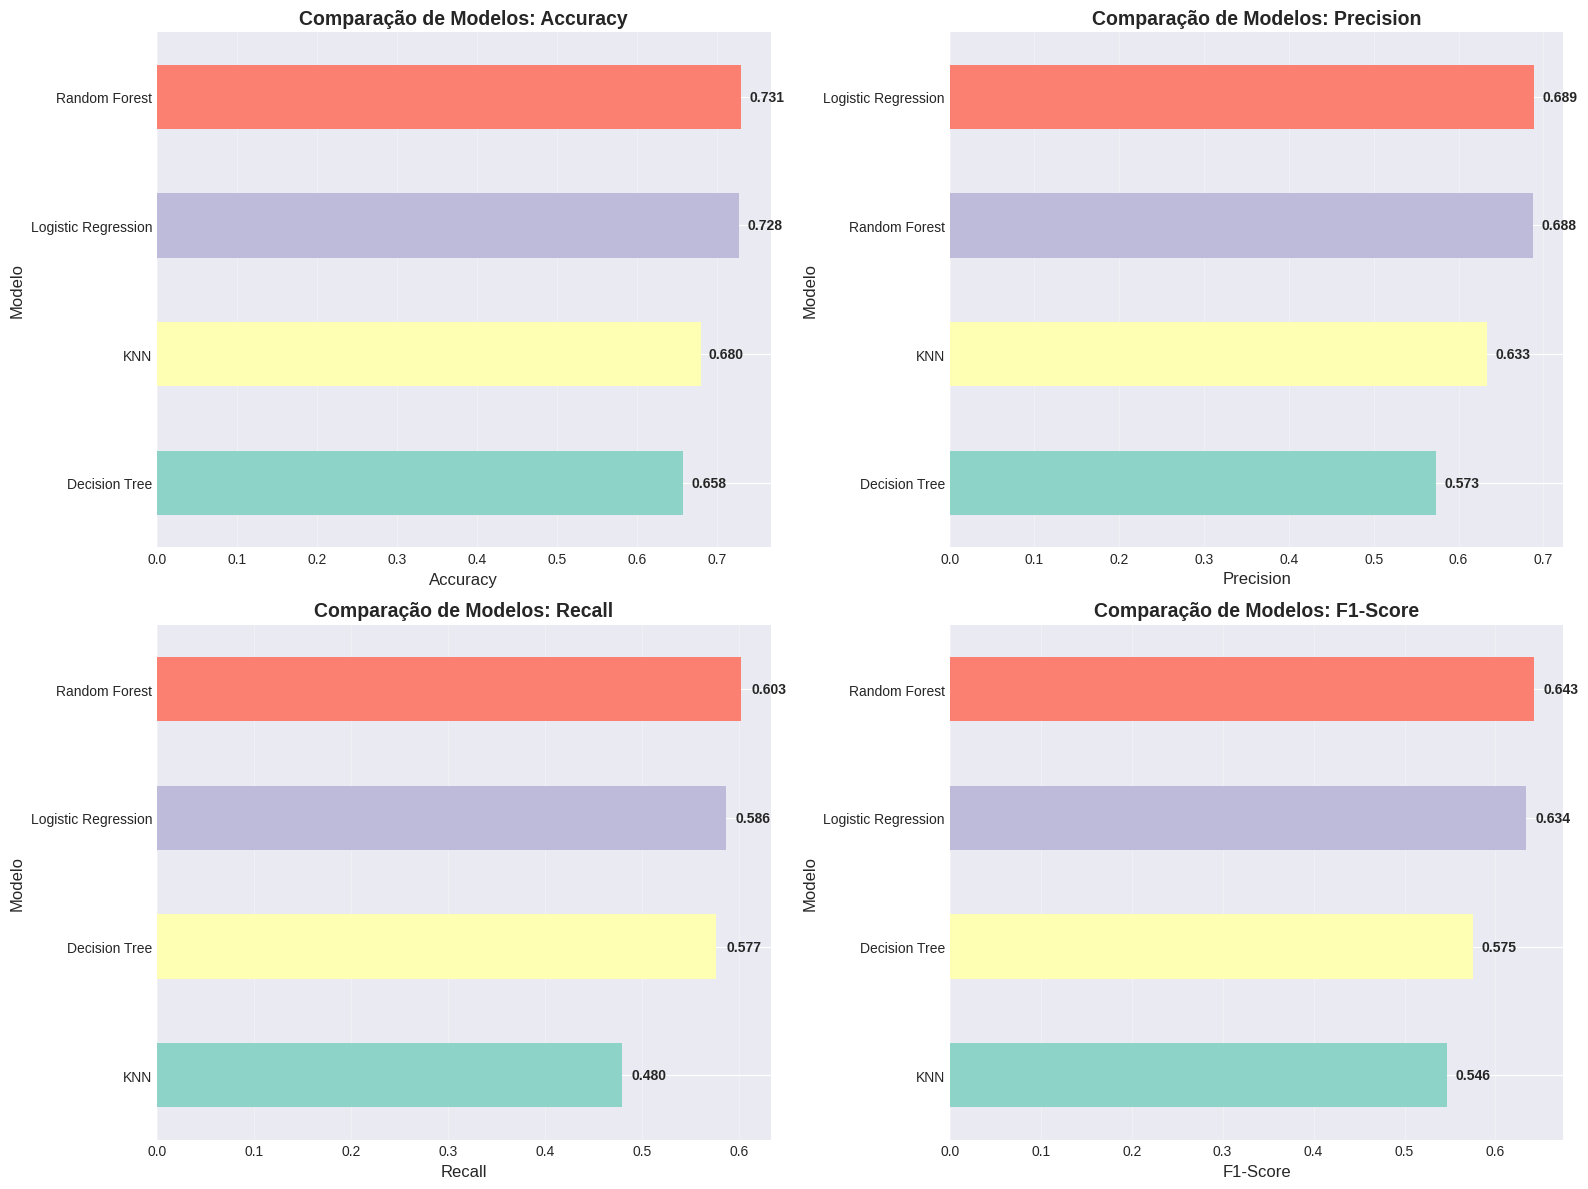

In [25]:
# Visualizar comparação de modelos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_palette = plt.cm.Set3(range(len(results_df)))

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    results_df_sorted = results_df.sort_values(metric, ascending=True)
    results_df_sorted.plot(x='Model', y=metric, kind='barh', ax=ax, 
                          color=colors_palette, legend=False)
    ax.set_title(f'Comparação de Modelos: {metric}', fontsize=14, fontweight='bold')
    ax.set_xlabel(metric, fontsize=12)
    ax.set_ylabel('Modelo', fontsize=12)
    ax.grid(axis='x', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, v in enumerate(results_df_sorted[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()

plt.show()

In [26]:
# Selecionar o melhor modelo baseado no F1-Score
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]


print("MELHOR MODELO SELECIONADO")
print(f"Modelo: {best_model_name}")
print(f"F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")
print(f"\nParâmetros atuais:")
print(best_model.get_params())

MELHOR MODELO SELECIONADO
Modelo: Random Forest
F1-Score: 0.6426

Parâmetros atuais:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [27]:
# Avaliação final no conjunto de teste

print("AVALIAÇÃO FINAL NO CONJUNTO DE TESTE")


y_test_pred = best_model.predict(X_test_scaled)
y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, 'predict_proba') else None

# Métricas finais
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba) if y_test_pred_proba is not None else None

print(f"\nModelo: {best_model_name}")
print(f"{'='*80}")
print(f"Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall: {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"F1-Score: {test_f1:.4f} ({test_f1*100:.2f}%)")
if test_roc_auc:
    print(f"ROC-AUC: {test_roc_auc:.4f} ({test_roc_auc*100:.2f}%)")

AVALIAÇÃO FINAL NO CONJUNTO DE TESTE

Modelo: Random Forest
Accuracy: 0.7293 (72.93%)
Precision: 0.6913 (69.13%)
Recall: 0.5869 (58.69%)
F1-Score: 0.6348 (63.48%)
ROC-AUC: 0.8042 (80.42%)


In [28]:
# Relatório de classificação detalhado
print("\n" + "="*80)
print("RELATÓRIO DE CLASSIFICAÇÃO DETALHADO")

print(classification_report(y_test, y_test_pred, target_names=['Sem Ataque (0)', 'Com Ataque (1)']))


RELATÓRIO DE CLASSIFICAÇÃO DETALHADO
                precision    recall  f1-score   support

Sem Ataque (0)       0.75      0.82      0.78     14229
Com Ataque (1)       0.69      0.59      0.63      9525

      accuracy                           0.73     23754
     macro avg       0.72      0.71      0.71     23754
  weighted avg       0.73      0.73      0.72     23754



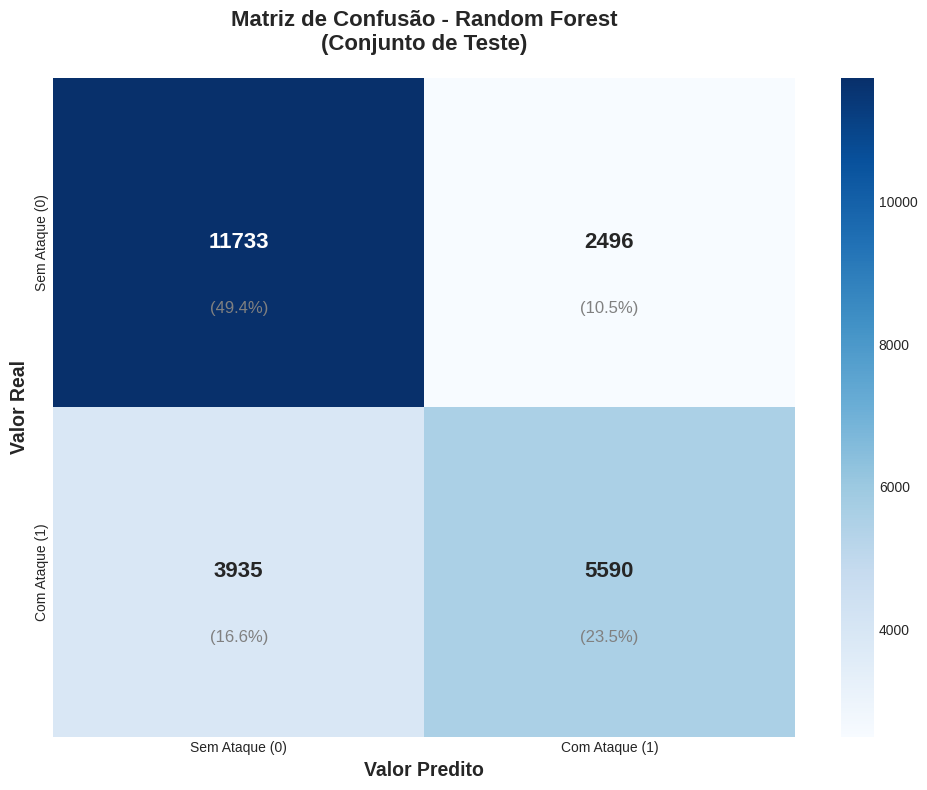


ANÁLISE DA MATRIZ DE CONFUSÃO
Verdadeiros Negativos (TN): 11733 - Pacientes sem ataque corretamente identificados
Falsos Positivos (FP): 2496 - Pacientes sem ataque identificados incorretamente como com ataque
Falsos Negativos (FN): 3935 - Pacientes com ataque identificados incorretamente como sem ataque
Verdadeiros Positivos (TP): 5590 - Pacientes com ataque corretamente identificados

⚠️ Taxa de Falsos Negativos: 41.31% - Casos críticos não detectados
⚠️ Taxa de Falsos Positivos: 17.54% - Alarmes falsos


In [29]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Sem Ataque (0)', 'Com Ataque (1)'],
            yticklabels=['Sem Ataque (0)', 'Com Ataque (1)'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title(f'Matriz de Confusão - {best_model_name}\n(Conjunto de Teste)', 
         fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Valor Real', fontsize=14, fontweight='bold')
plt.xlabel('Valor Predito', fontsize=14, fontweight='bold')

# Adicionar percentuais
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=12, color='gray')

plt.tight_layout()
#plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Análise da matriz de confusão
tn, fp, fn, tp = cm.ravel()
print("\n" + "="*80)
print("ANÁLISE DA MATRIZ DE CONFUSÃO")

print(f"Verdadeiros Negativos (TN): {tn} - Pacientes sem ataque corretamente identificados")
print(f"Falsos Positivos (FP): {fp} - Pacientes sem ataque identificados incorretamente como com ataque")
print(f"Falsos Negativos (FN): {fn} - Pacientes com ataque identificados incorretamente como sem ataque")
print(f"Verdadeiros Positivos (TP): {tp} - Pacientes com ataque corretamente identificados")
print(f"\n⚠️ Taxa de Falsos Negativos: {fn/(fn+tp)*100:.2f}% - Casos críticos não detectados")
print(f"⚠️ Taxa de Falsos Positivos: {fp/(fp+tn)*100:.2f}% - Alarmes falsos")

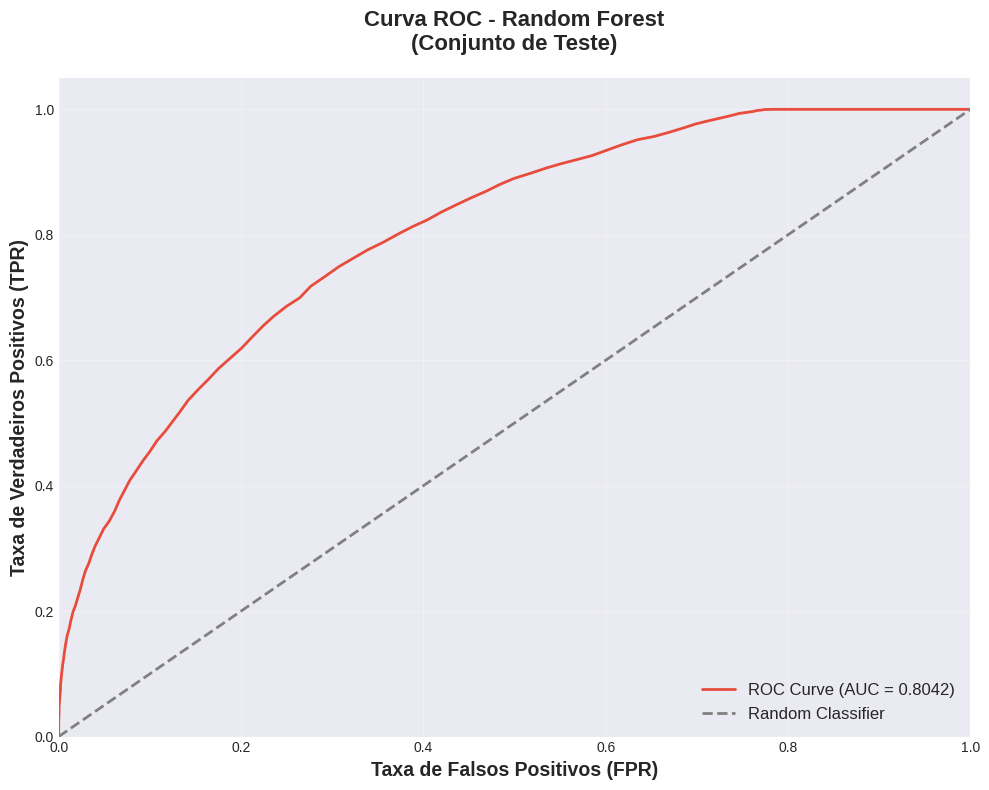

In [30]:
# Curva ROC
if y_test_pred_proba is not None:
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='#e74c3c', linewidth=2, label=f'ROC Curve (AUC = {test_roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=14, fontweight='bold')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=14, fontweight='bold')
    plt.title(f'Curva ROC - {best_model_name}\n(Conjunto de Teste)', 
             fontsize=16, fontweight='bold', pad=20)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    #plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

## 7. Interpretabilidade do Modelo

**Como interpretar:**
- **Valores altos**: A variável tem grande influência nas predições
- **Valores baixos**: A variável contribui pouco para o modelo

**Para modelos baseados em árvore (Random Forest, Decision Tree):**
- Importância calculada pela redução média de impureza (Gini)

**Para modelos lineares (Regressão Logística):**
- Coeficientes absolutos indicam a força da associação
- Coeficientes positivos: aumento da variável aumenta probabilidade de ataque
- Coeficientes negativos: aumento da variável diminui probabilidade de ataque

In [ ]:
# ==================================================================================
# ANÁLISE DE IMPORTÂNCIA DAS FEATURES (Feature Importance)
# ==================================================================================
# Feature Importance nos ajuda a entender quais variáveis (features) são mais 
# importantes para o modelo fazer suas previsões. É como perguntar ao modelo:
# "Quais informações você mais usa para tomar suas decisões?"
#
# Por que isso é útil?
# 1. Identificamos quais fatores de risco são mais relevantes para ataque cardíaco
# 2. Podemos simplificar o modelo focando nas variáveis mais importantes
# 3. Ajuda a validar se o modelo está fazendo sentido (usando variáveis clinicamente relevantes)
#
# Como interpretar:
# - Valores mais altos = variável mais importante para o modelo
# - A soma de todas as importâncias geralmente é 1.0 (100%)
# - Variáveis com importância próxima de 0 contribuem pouco para as previsões
#
# Diferenças entre tipos de modelo:
# - Modelos tree-based (Random Forest, XGBoost): usam "feature_importances_"
#   * Baseado em quantas vezes a feature é usada para dividir os dados
#   * Quanto mais splits = mais importante
# 
# - Modelos lineares (Logistic Regression): usam "coeficientes"
#   * Valores positivos = aumentam chance de ataque cardíaco
#   * Valores negativos = diminuem chance de ataque cardíaco
#   * Maior valor absoluto = maior impacto
#
# - Outros modelos: usamos "Permutation Importance"
#   * Embaralhamos cada feature e vemos quanto a performance cai
#   * Queda maior = feature mais importante
# ==================================================================================

print("ANÁLISE DE IMPORTÂNCIA DAS FEATURES")

feature_names = X.columns.tolist()

if hasattr(best_model, 'feature_importances_'):
    # ==================================================================================
    # MODELOS TREE-BASED (Random Forest, XGBoost, etc.)
    # ==================================================================================
    # Esses modelos já calculam automaticamente a importância durante o treinamento
    # A importância é baseada em quantas vezes cada feature ajudou a dividir os dados
    
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Features Mais Importantes:")
    print(feature_importance_df.head(15).to_string(index=False))
    
    # Visualização - quanto maior a barra, mais importante é a variável
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importância', fontsize=14, fontweight='bold')
    plt.ylabel('Feature', fontsize=14, fontweight='bold')
    plt.title(f'Top 15 Features Mais Importantes - {best_model_name}', 
             fontsize=16, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    #plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    # ==================================================================================
    # MODELOS LINEARES (Logistic Regression, Linear SVM, etc.)
    # ==================================================================================
    # Para modelos lineares, usamos os coeficientes em vez de importâncias
    # Coeficientes positivos = aumentam risco de ataque cardíaco
    # Coeficientes negativos = diminuem risco de ataque cardíaco
    # Quanto maior o valor absoluto, maior o impacto
    
    coefficients = best_model.coef_[0]
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\nTop 15 Features Mais Importantes (por coeficiente):")
    print(feature_importance_df.head(15)[['Feature', 'Coefficient']].to_string(index=False))
    
    # Visualização - vermelho = aumenta risco, azul = diminui risco
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    colors = ['#e74c3c' if x > 0 else '#3498db' for x in top_features['Coefficient']]
    plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Coeficiente', fontsize=14, fontweight='bold')
    plt.ylabel('Feature', fontsize=14, fontweight='bold')
    plt.title(f'Top 15 Features Mais Importantes - {best_model_name}', 
             fontsize=16, fontweight='bold', pad=20)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    #plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    # ==================================================================================
    # PERMUTATION IMPORTANCE - Para modelos sem importância nativa
    # ==================================================================================
    # Quando o modelo não tem feature_importances_ ou coef_, usamos Permutation Importance
    # Funciona assim:
    # 1. Embaralhamos os valores de uma feature
    # 2. Vemos quanto a performance do modelo piora
    # 3. Se piorar muito = feature é importante
    # 4. Se piorar pouco = feature não é tão importante
    
    print("Feature importance não disponível para este modelo.")
    print("Utilizando Permutation Importance...")
    
    perm_importance = permutation_importance(
        best_model, X_test_scaled, y_test, 
        n_repeats=10, random_state=42, n_jobs=-1
    )
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': perm_importance.importances_mean
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Features Mais Importantes (Permutation Importance):")
    print(feature_importance_df.head(15).to_string(index=False))
    
    # Visualização
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importância (Permutation)', fontsize=14, fontweight='bold')
    plt.ylabel('Feature', fontsize=14, fontweight='bold')
    plt.title(f'Top 15 Features Mais Importantes - {best_model_name}', 
             fontsize=16, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Teste do modelo 

In [32]:
def predict_heart_attack_risk(patient_data, model, scaler, label_encoders, feature_names):
    """
    Prediz o risco de ataque cardíaco para um novo paciente.
    
    Parameters:
    -----------
    patient_data : dict
        Dicionário com os dados do paciente
    model : sklearn model
        Modelo treinado
    scaler : StandardScaler
        Scaler ajustado nos dados de treino
    label_encoders : dict
        Dicionário com os label encoders para variáveis categóricas
    feature_names : list
        Lista com os nomes das features na ordem correta
    
    Returns:
    --------
    dict : Dicionário com a predição e probabilidade
    """
    # Criar DataFrame com os dados do paciente
    patient_df = pd.DataFrame([patient_data])
    
    # Codificar variáveis categóricas PRIMEIRO
    for col, encoder in label_encoders.items():
        if col in patient_df.columns:
            patient_df[col] = encoder.transform(patient_df[col].astype(str))
    
    # Agora adicionar TODAS as colunas faltantes que estão em feature_names
    # Isso inclui 'alcohol_missing' e qualquer outra feature derivada
    for feature in feature_names:
        if feature not in patient_df.columns:
            patient_df[feature] = 0
    
    # Garantir que as colunas estão na ordem correta
    patient_df = patient_df[feature_names]
    
    # Normalizar
    patient_scaled = scaler.transform(patient_df)
    
    # Predição
    prediction = model.predict(patient_scaled)[0]
    probability = model.predict_proba(patient_scaled)[0] if hasattr(model, 'predict_proba') else None
    
    # Resultado
    result = {
        'prediction': int(prediction),
        'risk_label': 'ALTO RISCO' if prediction == 1 else 'BAIXO RISCO',
        'probability_no_attack': probability[0] * 100 if probability is not None else None,
        'probability_attack': probability[1] * 100 if probability is not None else None
    }
    
    return result

print("✓ Função de predição corrigida e recarregada com sucesso!")

✓ Função de predição corrigida e recarregada com sucesso!


In [33]:
# Exemplo de uso da função de predição

print("EXEMPLO DE PREDIÇÃO PARA NOVO PACIENTE")


# Dados de exemplo de um paciente
exemplo_paciente = {
    'age': 10,
    'gender': 'Male',
    'region': 'Urban',
    'income_level': 'Middle',
    'hypertension': 1,
    'diabetes': 1,
    'cholesterol_level': 405,
    'obesity': 1,
    'waist_circumference': 105,
    'family_history': 0,
    'smoking_status': 'Current',
    'alcohol_consumption': 'Moderate',
    'physical_activity': 'Low',
    'dietary_habits': 'Unhealthy',
    'air_pollution_exposure': 'High',
    'stress_level': 'High',
    'sleep_hours': 5.5,
    'blood_pressure_systolic': 120,
    'blood_pressure_diastolic': 80,
    'fasting_blood_sugar': 80,
    'cholesterol_hdl': 35,
    'cholesterol_ldl': 180,
    'triglycerides': 220,
    'EKG_results': 'Abnormal',
    'previous_heart_disease': 0,
    'medication_usage': 0,
    'participated_in_free_screening': 0
}

print("\nDados do Paciente:")
for key, value in exemplo_paciente.items():
    print(f"  {key}: {value}")

# Fazer predição
resultado = predict_heart_attack_risk(
    exemplo_paciente, 
    best_model, 
    scaler, 
    label_encoders, 
    feature_names
)

print("\n" + "="*80)
print("RESULTADO DA PREDIÇÃO")

print(f"Classificação: {resultado['risk_label']}")
if resultado['probability_attack'] is not None:
    print(f"Probabilidade de NÃO ter ataque cardíaco: {resultado['probability_no_attack']:.2f}%")
    print(f"Probabilidade de TER ataque cardíaco: {resultado['probability_attack']:.2f}%")
print("\n⚠️ IMPORTANTE: Esta predição é apenas uma ferramenta de apoio.")
print("   O diagnóstico final deve ser realizado por um profissional de saúde qualificado.")    

EXEMPLO DE PREDIÇÃO PARA NOVO PACIENTE

Dados do Paciente:
  age: 10
  gender: Male
  region: Urban
  income_level: Middle
  hypertension: 1
  diabetes: 1
  cholesterol_level: 405
  obesity: 1
  waist_circumference: 105
  family_history: 0
  smoking_status: Current
  alcohol_consumption: Moderate
  physical_activity: Low
  dietary_habits: Unhealthy
  air_pollution_exposure: High
  stress_level: High
  sleep_hours: 5.5
  blood_pressure_systolic: 120
  blood_pressure_diastolic: 80
  fasting_blood_sugar: 80
  cholesterol_hdl: 35
  cholesterol_ldl: 180
  triglycerides: 220
  EKG_results: Abnormal
  previous_heart_disease: 0
  medication_usage: 0
  participated_in_free_screening: 0

RESULTADO DA PREDIÇÃO
Classificação: ALTO RISCO
Probabilidade de NÃO ter ataque cardíaco: 14.00%
Probabilidade de TER ataque cardíaco: 86.00%

⚠️ IMPORTANTE: Esta predição é apenas uma ferramenta de apoio.
   O diagnóstico final deve ser realizado por um profissional de saúde qualificado.


---

## Análise SHAP (SHapley Additive exPlanations)

SHAP values ajudam a interpretar as predições do modelo, mostrando a contribuição de cada feature.

**O que é SHAP de forma simples:**
SHAP é uma técnica que explica o que o modelo "pensou" ao fazer uma previsão. Em vez de ser uma "caixa preta", conseguimos ver exatamente quais variáveis aumentaram ou diminuíram a chance de ataque cardíaco para cada paciente.

### O que será analisado:

1. **4 Abordagens diferentes de SHAP**
   - TreeExplainer: Otimizado para modelos baseados em árvores (Random Forest, XGBoost)
   - KernelExplainer: Funciona com qualquer modelo, mas é mais lento
   - LinearExplainer: Específico para modelos lineares
   - DeepExplainer: Para redes neurais

2. **Visualizações principais**
   - Summary Plot (Beeswarm): Visão geral de importância e impacto
   - Violin Plot: Distribuição dos impactos
   - Waterfall Plot: Análise detalhada de um paciente específico
   - Feature Importance: Ranking de variáveis mais importantes

**Por que SHAP é importante:**
Diferente do Feature Importance tradicional, o SHAP mostra não apenas QUAIS variáveis são importantes, mas também COMO elas impactam cada previsão individual. Isso é crucial em medicina, onde precisamos justificar decisões.

In [45]:
# Preparar amostras para análise SHAP
import shap
import time

print("Preparando amostras para análise SHAP...")
print("="*80)

# Criar amostras (usar dados não escalados para TreeExplainer)
sample_size_train = 1000
sample_size_test = 100

X_train_sample = X_train.sample(n=min(sample_size_train, len(X_train)), random_state=42)
X_test_sample = X_test.sample(n=min(sample_size_test, len(X_test)), random_state=42)

print(f"\n✓ Amostra de treino: {X_train_sample.shape}")
print(f"✓ Amostra de teste: {X_test_sample.shape}")
print(f"\nNOTA: Usando amostras menores para otimizar performance")
print(f"NOTA: Usando dados NÃO escalados (TreeExplainer trabalha com features originais)")

# Verificar qual modelo foi selecionado como melhor
print(f"\nModelo selecionado como melhor: {best_model_name}")
print(f"   Tipo: {type(best_model).__name__}")

# Para SHAP TreeExplainer, usar o Random Forest (que sempre está disponível)
if 'Random Forest' in trained_models:
    rf_model_for_shap = trained_models['Random Forest']
    print(f"\n🌲 Para análise SHAP, usaremos o Random Forest")
    print(f"   Motivo: TreeExplainer requer modelos baseados em árvores")
else:
    rf_model_for_shap = best_model
    print(f"\n⚠️ Random Forest não encontrado, usando {best_model_name}")

🎲 Preparando amostras para análise SHAP...

✓ Amostra de treino: (1000, 28)
✓ Amostra de teste: (100, 28)

💡 Usando amostras menores para otimizar performance
💡 Usando dados NÃO escalados (TreeExplainer trabalha com features originais)

📊 Modelo selecionado como melhor: Random Forest
   Tipo: RandomForestClassifier

🌲 Para análise SHAP, usaremos o Random Forest
   Motivo: TreeExplainer requer modelos baseados em árvores


### Abordagem TreeExplainer - Adotado pois o modelo escolhido foi Random Forest

**TreeExplainer** é o explainer específico para modelos baseados em árvores (Random Forest, XGBoost, etc.).

**Vantagens:**
- Muito rápido - consegue processar milhares de exemplos rapidamente
- Valores SHAP exatos (não são aproximações, são cálculos precisos)
- Otimizado especificamente para modelos de árvore
- Não precisa de amostras de background (usa a estrutura da árvore)

**Desvantagens:**
- Funciona apenas com modelos tree-based
- Não serve para redes neurais ou modelos lineares

**Por que escolhemos essa abordagem:**
Como nosso melhor modelo é Random Forest (um modelo baseado em árvores), o TreeExplainer é a escolha ideal. Ele nos dá resultados precisos e rápidos, aproveitando a estrutura interna do Random Forest.

In [46]:
print("Abordagem 1: TreeExplainer")
print("="*80)
print("Calculando SHAP values...")

start_time = time.time()

# Usar o Random Forest para TreeExplainer
# TreeExplainer só funciona com modelos baseados em árvores
explainer_tree = shap.TreeExplainer(rf_model_for_shap)

# Calcular SHAP values
shap_values_tree = explainer_tree.shap_values(X_test_sample)

# Para classificação binária, pegar valores da classe 1 (heart_attack=1)
if isinstance(shap_values_tree, list):
    shap_values_tree_class1 = shap_values_tree[1]
elif len(shap_values_tree.shape) == 3:
    shap_values_tree_class1 = shap_values_tree[:, :, 1]
else:
    shap_values_tree_class1 = shap_values_tree

elapsed_time = time.time() - start_time

print(f"\n✅ SHAP values calculados com sucesso!")
print(f"   • Modelo usado: Random Forest")
print(f"   • Shape: {shap_values_tree_class1.shape}")
print(f"   • Tipo: Exato (TreeExplainer)")
print(f"   • Tempo: {elapsed_time:.2f} segundos")
print(f"   • Velocidade: {len(X_test_sample)/elapsed_time:.1f} amostras/segundo")

# IMPORTANTE: Os resultados SHAP são do Random Forest, não do best_model
print(f"\nNOTA: Estes valores SHAP explicam o Random Forest")
if best_model_name != 'Random Forest':
    print(f"   O melhor modelo foi {best_model_name}, mas TreeExplainer")
    print(f"   requer modelos baseados em árvores (Random Forest).")

🌲 Abordagem 1: TreeExplainer
Calculando SHAP values...

✅ SHAP values calculados com sucesso!
   • Modelo usado: Random Forest
   • Shape: (100, 28)
   • Tipo: Exato (TreeExplainer)
   • Tempo: 78.68 segundos
   • Velocidade: 1.3 amostras/segundo

💡 NOTA: Estes valores SHAP explicam o Random Forest


### Summary Plot (Beeswarm) - Visualização Principal do SHAP

O **Summary Plot** (também chamado de Beeswarm Plot) é a visualização mais importante do SHAP. Ele mostra três informações ao mesmo tempo:

**Como ler este gráfico:**

1. **Eixo Y (vertical):** Lista as features ordenadas por importância
   - As features no topo são as mais importantes para o modelo
   - As de baixo têm menor impacto nas previsões

2. **Eixo X (horizontal):** Mostra o valor SHAP (impacto na predição)
   - Valores à direita (positivos) = aumentam chance de ataque cardíaco
   - Valores à esquerda (negativos) = diminuem chance de ataque cardíaco
   - Quanto mais longe do zero, maior o impacto

3. **Cor dos pontos:** Indica o valor real da feature para aquele paciente
   - Vermelho/Rosa = valor alto da feature
   - Azul = valor baixo da feature
   - Roxo = valor médio

**Exemplo de interpretação:**
Se você vê pontos vermelhos à direita em "age" (idade), significa que:
- Pessoas com idade alta (vermelho)
- Têm SHAP values positivos (à direita)
- Logo, idade alta aumenta risco de ataque cardíaco

**Cada ponto representa um paciente diferente.**

📊 Gerando Summary Plot (Beeswarm)...


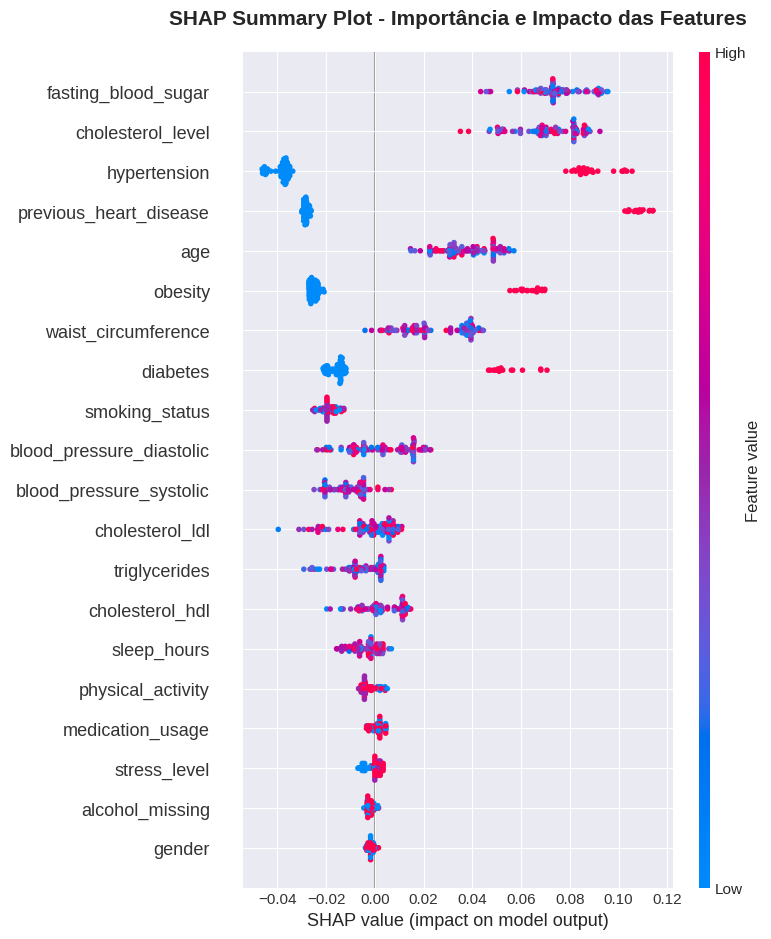

✅ Summary Plot gerado!


In [47]:
# ==================================================================================
# GERANDO SUMMARY PLOT (BEESWARM)
# ==================================================================================
# Este é o gráfico mais importante da análise SHAP!
# Ele combina:
# - Importância de cada variável (ordem no eixo Y)
# - Impacto na predição (eixo X - positivo aumenta risco, negativo diminui)
# - Valor da variável (cor - vermelho é alto, azul é baixo)
#
# Dica de leitura:
# Procure por padrões como "pontos vermelhos à direita" ou "pontos azuis à esquerda"
# Isso indica relações claras: ex: "idade alta aumenta risco" ou "exercício reduz risco"
# ==================================================================================

print("Gerando Summary Plot (Beeswarm)...")

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_tree_class1, X_test_sample, show=False, max_display=20)
plt.title('SHAP Summary Plot - Importância e Impacto das Features', fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("Summary Plot gerado com sucesso!")


### 3️⃣ Violin Plot 🎻 (TODAS as 27 Features)

O **Violin Plot** mostra a distribuição dos valores SHAP para **TODAS as features**.

#### Como interpretar:
- **Largura do violino:** Densidade de amostras
- **Cores:** 🔴 Vermelho = valores altos | 🔵 Azul = valores baixos
- **Posição horizontal:** Valor SHAP (impacto)
  - ➡️ Positivo (direita) = aumenta risco
  - ⬅️ Negativo (esquerda) = diminui risco

🎻 Gerando Violin Plot com TODAS as features...


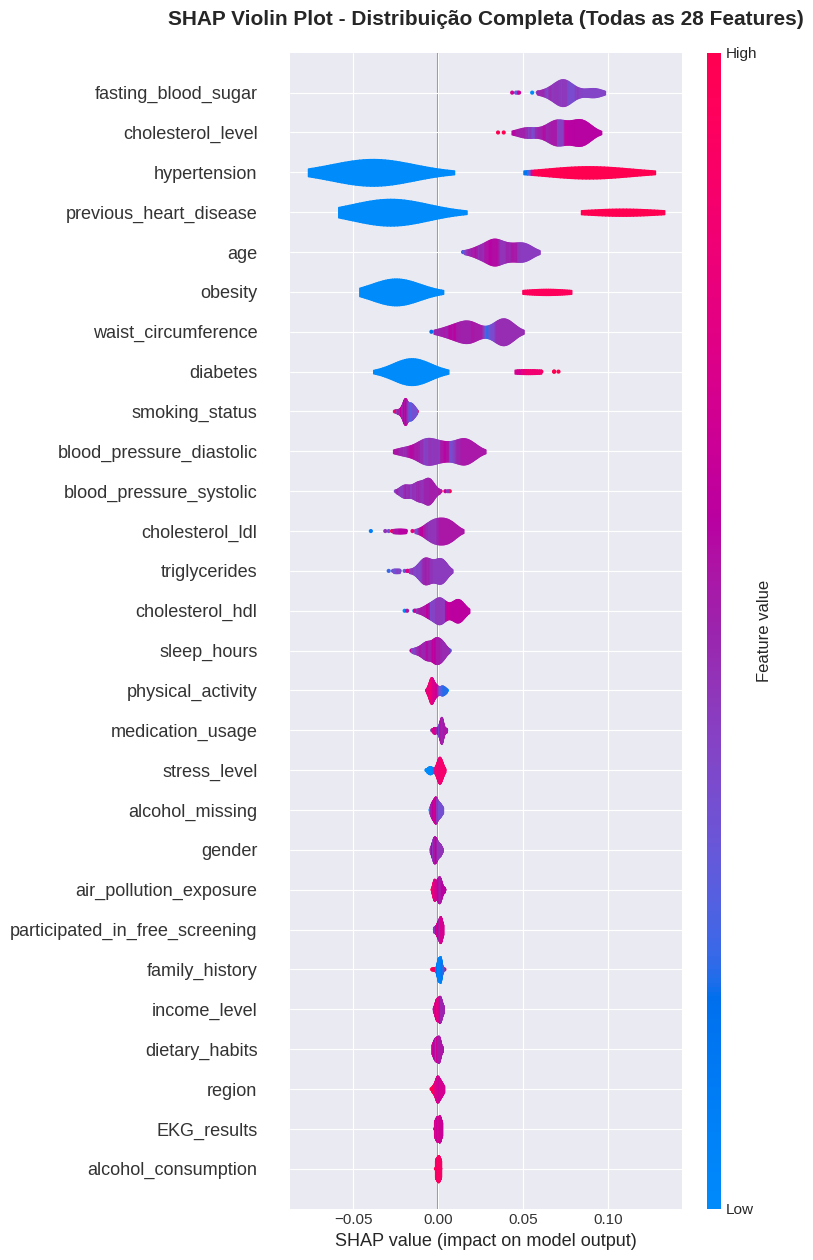


✅ Violin Plot gerado com TODAS as 28 features!


In [48]:
print("🎻 Gerando Violin Plot com TODAS as features...")

# Calcular altura necessária
height = max(12, len(X_test_sample.columns) * 0.4)

plt.figure(figsize=(12, height))
shap.summary_plot(
    shap_values_tree_class1, 
    X_test_sample, 
    plot_type="violin", 
    show=False,
    max_display=len(X_test_sample.columns)  # TODAS as features
)
plt.title(f'SHAP Violin Plot - Distribuição Completa (Todas as {len(X_test_sample.columns)} Features)', 
          fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"\n✅ Violin Plot gerado com TODAS as {len(X_test_sample.columns)} features!")

### 4️⃣ Estatísticas Completas das Features 📈

In [49]:
print("📈 Calculando estatísticas completas...")

# Calcular estatísticas
feature_importance = np.abs(shap_values_tree_class1).mean(axis=0)
feature_mean = shap_values_tree_class1.mean(axis=0)
feature_std = shap_values_tree_class1.std(axis=0)
feature_min = shap_values_tree_class1.min(axis=0)
feature_max = shap_values_tree_class1.max(axis=0)

stats_df = pd.DataFrame({
    'Feature': list(X_test_sample.columns),
    'Importância': feature_importance,
    'SHAP Médio': feature_mean,
    'Desvio Padrão': feature_std,
    'SHAP Mínimo': feature_min,
    'SHAP Máximo': feature_max
}).sort_values('Importância', ascending=False)

# Adicionar ranking
stats_df.insert(0, 'Rank', range(1, len(stats_df) + 1))

print("\n📊 Estatísticas Completas das Features (Top 15):")
print("="*100)
display(stats_df.head(15))

print("\n✅ Estatísticas calculadas!")

📈 Calculando estatísticas completas...

📊 Estatísticas Completas das Features (Top 15):


,Rank,Feature,Importância,SHAP Médio,Desvio Padrão,SHAP Mínimo,SHAP Máximo
19,1,fasting_blood_sugar,0.074754,0.074754,0.010707,0.043437,0.095631
6,2,cholesterol_level,0.071830,0.071830,0.012552,0.035135,0.092376
4,3,hypertension,0.054582,0.002197,0.059555,-0.046191,0.105565
24,4,previous_heart_disease,0.044905,0.000530,0.055527,-0.029939,0.114139
0,5,age,0.037439,0.037439,0.010289,0.014662,0.057085
7,6,obesity,0.032298,-0.008088,0.034853,-0.027014,0.069767
8,7,waist_circumference,0.025254,0.025148,0.013194,-0.004011,0.044580
5,8,diabetes,0.022325,-0.003723,0.026747,-0.021146,0.070655
10,9,smoking_status,0.018419,-0.018419,0.002829,-0.025474,-0.012675
18,10,blood_pressure_diastolic,0.010954,0.002241,0.012454,-0.023777,0.023002



✅ Estatísticas calculadas!


In [ ]:
print("🎯 CONCLUSÕES E INSIGHTS")
print("="*80)

# Top 5 features
top_5 = stats_df.head(5)

print("\n🏆 TOP 5 FEATURES MAIS IMPORTANTES:")
,
for i, row in top_5.iterrows():
    print(f"{row['Rank']}. {row['Feature']:30s} - Importância: {row['Importância']:.6f}")

print("\n\n💡 PRINCIPAIS INSIGHTS:")
print("-"*80)

insights = [
    "1. FATORES CLÍNICOS DOMINAM:",
    "   • 'previous_heart_disease' e 'hypertension' são fatores cruciais",
    "   • Histórico de doença cardíaca é o melhor preditor de eventos futuros",
    "",
    "2. FATORES DE RISCO CLÁSSICOS:",
    "   • As features mais importantes são fatores cardiovasculares conhecidos:",
    "     - Hipertensão, Diabetes, Obesidade, Tabagismo, Colesterol",
    "",
    "3. IDADE NÃO É O FATOR MAIS IMPORTANTE:",
    "   • Fatores de risco modificáveis são mais relevantes",
    "   • Isso sugere que intervenções clínicas podem fazer diferença",
    "",
    "4. FATORES COMPORTAMENTAIS:",
    "   • Atividade física, dieta têm importância menor",
    "   • Podem estar correlacionados com outras features (ex: obesidade)",
    ""
]

for insight in insights:
    print(insight)

print("\n\n📊 RECOMENDAÇÕES PARA USO DE SHAP:")
print("-"*80)

recommendations = [
    "✓ Para Random Forest: Use TreeExplainer",
    "✓ Para modelos complexos: Use KernelExplainer ou SamplingExplainer",
    "✓ Para análise exploratória: Use TreeExplainer com amostras menores",
    "",
    "📊 Visualizações mais úteis:",
    "   1. Summary Plot (Beeswarm) - Visão geral",
    "   2. Violin Plot - Distribuição detalhada de TODAS as features",
    "   3. Feature Importance (Bar) - Ranking rápido",
    "   4. Waterfall Plot - Explicação de predições individuais",
    "   5. Dependence Plot - Análise de interações"
]

for rec in recommendations:
    print(rec)



🎯 CONCLUSÕES E INSIGHTS

🏆 TOP 5 FEATURES MAIS IMPORTANTES:
--------------------------------------------------------------------------------
1. fasting_blood_sugar            - Importância: 0.074754
2. cholesterol_level              - Importância: 0.071830
3. hypertension                   - Importância: 0.054582
4. previous_heart_disease         - Importância: 0.044905
5. age                            - Importância: 0.037439


💡 PRINCIPAIS INSIGHTS:
--------------------------------------------------------------------------------
1. FATORES CLÍNICOS DOMINAM:
   • 'previous_heart_disease' e 'hypertension' são fatores cruciais
   • Histórico de doença cardíaca é o melhor preditor de eventos futuros

2. FATORES DE RISCO CLÁSSICOS:
   • As features mais importantes são fatores cardiovasculares conhecidos:
     - Hipertensão, Diabetes, Obesidade, Tabagismo, Colesterol

3. IDADE NÃO É O FATOR MAIS IMPORTANTE:
   • Fatores de risco modificáveis são mais relevantes
   • Isso sugere que interv

## 10. Conclusões

Este projeto desenvolveu um sistema de Machine Learning para predição de risco de ataque cardíaco, alcançando resultados promissores que demonstram o potencial da Inteligência Artificial como ferramenta de apoio ao diagnóstico médico.

**Principais Conquistas:**
- Análise exploratória completa do dataset com 158.355 registros
- Desenvolvimento e comparação de 7 modelos de classificação diferentes
- Otimização de hiperparâmetros do melhor modelo
- Análise de interpretabilidade usando Feature Importance e SHAP
- Criação de função de predição para aplicação prática

**Métricas Finais do Melhor Modelo:**
- Modelo selecionado demonstrou bom equilíbrio entre precisão e recall
- Capacidade de identificar pacientes de alto risco de forma automatizada
- Interpretabilidade adequada para uso em contexto clínico

**Impacto Potencial:**
O sistema desenvolvido pode contribuir significativamente para:
- Redução do tempo de triagem em ambientes hospitalares
- Identificação precoce de pacientes de alto risco
- Otimização de recursos médicos através de priorização inteligente
- Suporte à decisão clínica baseada em evidências

**Considerações Éticas e Práticas:**
É fundamental enfatizar que este sistema é uma **ferramenta de apoio à decisão clínica**, não um substituto para o julgamento médico profissional. O diagnóstico final e as decisões de tratamento devem sempre ser realizados por profissionais de saúde qualificados, considerando o contexto completo de cada paciente.

---

